### Rotating


In [1]:
from moviepy.editor import *
#your_video = "../dataset/good_sync/perry-all-2/P104_2020-12-06_121257717.mp4"
video_source = "P104_2020-12-06_120759384.mp4"
rotated_video_source = "rotated.mp4"
clip = VideoFileClip(video_source)
clip = clip.rotate(90)
clip.write_videofile(rotated_video_source)


chunk:   1%|          | 32/3529 [00:00<00:14, 239.99it/s, now=None]

Moviepy - Building video rotated.mp4.
MoviePy - Writing audio in rotatedTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/4801 [00:00<05:58, 13.39it/s, now=None]        

MoviePy - Done.
Moviepy - Writing video rotated.mp4



Moviepy - Done !
Moviepy - video ready rotated.mp4


# Basic engine implementation

#### setup

In [20]:
import face_recognition, PIL.Image, PIL.ImageDraw,math
import numpy as np
import logging
import cv2
import platform
from matplotlib import pyplot as plt
from PIL import Image
import scipy.signal as sig

FORMAT = '[%(asctime)s] [%(levelname)s] [%(funcName)s] [%(lineno)d] : %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

logging.info("Starting ...")
if platform.system() == "Windows":
    seperator = "\\"
else:
    seperator = "/"

dir = "perry-all-2"
# should be a parameter of the engine
dataset_location = ".." + seperator + "dataset" + seperator + "good_sync" + seperator
specific_dir = dir
#video_location = dataset_location + specific_dir + seperator + "lab1.mp4"
video_location = "rotated.mp4"

[2021-04-21 19:41:59,455] [INFO] [<module>] [13] : Starting ...


## running evm pre-processing

In [21]:
#%run ./evm_preprocessing.ipynb
# video_location = dataset_location + specific_dir + seperator + "out.avi"
#video_location="out2.avi"

#### Detecting the face landmarks and parsing the ROI

In [22]:
def parse_roi(frame):
    # image = face_recognition.load_image_file(frame) # read image.
    face_locations = face_recognition.face_locations(frame,model = 'hog') # detects all the faces in image
    face_landmarks_list = face_recognition.face_landmarks(image)
    
    # iterate through all the faces.
    for face_location in face_locations:
        img = PIL.Image.fromarray(frame)
        top,right,bottom,left = face_location # extract all face square points.
        diff = math.floor((top - bottom) * 0.15) # 20 percent of the face len (toadd eyebrow top point).
        
        # finding the forehead
        try:
            right_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['right_eyebrow']) # right eyebrow points.
        except:
            return None
        right_eyebrow_landmarks.sort(axis=0)
        rightest_point = right_eyebrow_landmarks[-1] # The most right point of the ROI(according to x).
        top_right_eyebrow = right_eyebrow_landmarks.min(axis = 0)[1]
        try:
            left_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['left_eyebrow'])
        except:
            return None
        left_eyebrow_landmarks.sort(axis=0)
        leftest_point = left_eyebrow_landmarks[0] # the most left point of ROI.(according to x)
        top_left_eyebrow = left_eyebrow_landmarks.min(axis = 0)[1]
        bottom = min(top_right_eyebrow,top_left_eyebrow).item(0) # bottom point of the forehead.
        bottom = bottom - (0.05 * bottom) # improve bottom location by 2 percent.
        forehead = img.crop((leftest_point[0], leftest_point[1]+diff, rightest_point[0],bottom+10)) # adding diff to top to make the forehead bigger.

        # finding the second ROI:
        try:
            upper_mouth = np.asarray(face_landmarks_list[0]['top_lip']) # top_lip landmarks
        except:
            return None
        upper_mouth_min = upper_mouth.min(axis = 0)[1] # The  top - lip upper point.
        try:
            upper_nose = np.asarray(face_landmarks_list[0]['nose_bridge'])
        except:
            return None
        upper_nose_min = upper_nose.min(axis = 0)[1]  # noise bridge upper point.
        upper_nose_min += upper_mouth_min * 0.1 # improving the noise bridge upper point.
        nose_to_upper_lip = img.crop((leftest_point[0], upper_nose_min, rightest_point[0], upper_mouth_min))

        return forehead, nose_to_upper_lip
    return None # in case of which no face was detected

### Check for bad frames
##### R > 95 and G > 40 and B > 20 and R > G and R > B
##### Based on https://arxiv.org/ftp/arxiv/papers/1708/1708.02694.pdf page 5

In [23]:
red_min_val = 95
green_min_val = 40
blue_min_val = 20
red_green_max_diff = 15
def good_frame(blue, green, red):
    if red <= red_min_val:
        logging.warning("bad frame detected, reason: red > red_min_val")
        return False
    if green <= green_min_val:
        logging.warning("bad frame detected, reason: green > green_min_val")
        return False
    if blue <= blue_min_val:
        logging.warning("bad frame detected, reason: blue > blue_min_val")
        return False
    if red <= green:
        logging.warning("bad frame detected, reason: red > green")
        return False
    if red <= blue:
        logging.warning("bad frame detected, reason: red > blue")
        return False
    if abs(red - green) <= red_green_max_diff:
        logging.warning("bad frame detected, reason: abs(red - green) > red_green_max_diff")
        return False

    return True

In [24]:
def get_new_frame(vidcap):
    success, next_image = vidcap.read()
    return success, next_image

#### Plotting RGB arrays results

In [25]:
def plot_result(greens, reds, blues, x_value, title=""):
    logging.info("Plotting results ..." + title)
    plt.figure(figsize=(6, 5))
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.subplot(3, 1, 1)
    plt.plot(x_value, greens, color="green")
    plt.subplot(3, 1, 2)
    plt.plot(x_value, reds, color="red")
    plt.subplot(3, 1, 3)
    plt.plot(x_value, blues, color="blue")
    plt.show()
    logging.info("Showing result")

#### Filtering:

In [26]:
def filter_channel(channel,fs):
    """
    This method apply filter on a channel between 0.75HZ to 4HZ.
    :param channel: Is a signal to apply the filter to.
    :param fs: Is the sampling rate of channel.
    :return: The filtered channel.
    """
    bh, ah = sig.butter(4, 0.75 / (fs / 2), 'highpass')
    bl, al = sig.butter(4, 4 / (fs / 2), 'lowpass')
    channel = sig.filtfilt(bh, ah, channel) # applying the filter coefficient on the sig
    #channel = np.absolute(channel)
    channel_after_filter = sig.filtfilt(bl, al, channel) # applying the filter coefficient on the sig
    return channel_after_filter

#### Getting RGB values from a frame and adding them to arrays

In [27]:
def parse_luminace(red, green, blue):
    luminance_level = 0.2126 * red + 0.7152 * green + 0.0722 * blue
    return luminance_level
def parse_RGB(roi, color_sig):
    """
    Parses an image to its RGB channels
    :param image: the image to be parsed
    :param vidcap:
    :param greens: array containing green channel values
    :param blues: array containing blue channel values
    :param reds: array containing red channel values
    :param frame_number - is the number of the frame of the video.
    :return: a flag indicating if there is a next image, and the next image
    """
#     plt.imshow(roi)
#     plt.show()
    try:
        roi = cv2.cvtColor(roi, cv2.COLOR_RGB2BGR)
    except:
        return False, color_sig
    new_blue,new_green,new_red = cv2.split(roi)
    b_mean,g_mean,r_mean = np.mean(new_blue),np.mean(new_green),np.mean(new_red)
    luminance_level = parse_luminace(r_mean, g_mean, b_mean)
    if good_frame(b_mean,g_mean,r_mean):
        color_channels = roi.reshape(-1, roi.shape[-1])
        avg_color = color_channels.mean(axis=0)
        color_sig.append(avg_color)
        return True, color_sig, luminance_level
    return False, color_sig, luminance_level

#### Main loop - going over all the frames of the video

In [28]:
color_sig = []
heart_rates = []
good_frame_number = 0
total_frame_number = 0

# Parsing video:
logging.info("Working on video " + video_location)
vidcap = cv2.VideoCapture(video_location)
success, image = vidcap.read()
fps = vidcap.get(cv2.CAP_PROP_FPS) # fs == sampling rate
round_fps = np.round(fps)
number_of_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
logging.info("Parsing images ...")
while success:
    logging.info("parsing frame " + str(total_frame_number) + "/" + str(number_of_frames))
    rois = parse_roi(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # build image ROI (rois is a tuple contains two regions)
    if rois is not None : 
        roi = np.asarray(rois[0]) # Just the forehead
        try:
            is_good_frame,color_sig, luminance_level = parse_RGB(roi, color_sig)
        except:
            logging.error("failed to get output from parse_RGB!")
            is_good_frame = False
        if is_good_frame:
            good_frame_number += 1
            logging.info("luminance level: " + str(luminance_level))
    total_frame_number += 1
    success, image = get_new_frame(vidcap)

[2021-04-21 19:41:59,555] [INFO] [<module>] [7] : Working on video rotated.mp4
[2021-04-21 19:41:59,640] [INFO] [<module>] [13] : Parsing images ...
[2021-04-21 19:41:59,642] [INFO] [<module>] [15] : parsing frame 0/4801.0
[2021-04-21 19:42:02,566] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:42:02,575] [INFO] [<module>] [15] : parsing frame 1/4801.0
[2021-04-21 19:42:04,806] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:42:04,810] [INFO] [<module>] [15] : parsing frame 2/4801.0
[2021-04-21 19:42:06,901] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:42:06,905] [INFO] [<module>] [15] : parsing frame 3/4801.0
[2021-04-21 19:42:09,004] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:42:09,010] [INFO] [<module>] [15] : parsing frame 4/4801.0
[2021-04-21 19:42:11,119] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:42:11,122] [INFO] [<m

[2021-04-21 19:43:56,596] [INFO] [<module>] [15] : parsing frame 50/4801.0
[2021-04-21 19:43:58,716] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:43:58,720] [INFO] [<module>] [15] : parsing frame 51/4801.0
[2021-04-21 19:44:00,905] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:44:00,909] [INFO] [<module>] [15] : parsing frame 52/4801.0
[2021-04-21 19:44:03,145] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:44:03,150] [INFO] [<module>] [15] : parsing frame 53/4801.0
[2021-04-21 19:44:05,267] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:44:05,271] [INFO] [<module>] [15] : parsing frame 54/4801.0
[2021-04-21 19:44:07,331] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:44:07,335] [INFO] [<module>] [15] : parsing frame 55/4801.0
[2021-04-21 19:44:09,409] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:4

[2021-04-21 19:45:47,111] [INFO] [<module>] [15] : parsing frame 101/4801.0
[2021-04-21 19:45:49,354] [INFO] [<module>] [15] : parsing frame 102/4801.0
[2021-04-21 19:45:51,461] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:45:51,465] [INFO] [<module>] [15] : parsing frame 103/4801.0
[2021-04-21 19:45:53,619] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:45:53,623] [INFO] [<module>] [15] : parsing frame 104/4801.0
[2021-04-21 19:45:55,752] [INFO] [<module>] [15] : parsing frame 105/4801.0
[2021-04-21 19:45:58,115] [INFO] [<module>] [15] : parsing frame 106/4801.0
[2021-04-21 19:46:01,019] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:46:01,034] [INFO] [<module>] [15] : parsing frame 107/4801.0
[2021-04-21 19:46:03,426] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:46:03,431] [INFO] [<module>] [15] : parsing frame 108/4801.0
[2021-04-21 19:46:05,523] [ERROR] [<

[2021-04-21 19:47:44,331] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:47:44,336] [INFO] [<module>] [15] : parsing frame 155/4801.0
[2021-04-21 19:47:46,548] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:47:46,551] [INFO] [<module>] [15] : parsing frame 156/4801.0
[2021-04-21 19:47:48,712] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:47:48,717] [INFO] [<module>] [15] : parsing frame 157/4801.0
[2021-04-21 19:47:50,851] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:47:50,855] [INFO] [<module>] [15] : parsing frame 158/4801.0
[2021-04-21 19:47:52,981] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:47:52,985] [INFO] [<module>] [15] : parsing frame 159/4801.0
[2021-04-21 19:47:55,112] [INFO] [<module>] [15] : parsing frame 160/4801.0
[2021-04-21 19:47:57,230] [INFO] [<module>] [15] : parsing frame 161/4801.0
[2021-04-21 19:47:59,37

[2021-04-21 19:49:34,092] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:49:34,097] [INFO] [<module>] [15] : parsing frame 206/4801.0
[2021-04-21 19:49:36,216] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:49:36,220] [INFO] [<module>] [15] : parsing frame 207/4801.0
[2021-04-21 19:49:38,327] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:49:38,331] [INFO] [<module>] [15] : parsing frame 208/4801.0
[2021-04-21 19:49:40,431] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:49:40,436] [INFO] [<module>] [15] : parsing frame 209/4801.0
[2021-04-21 19:49:42,559] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:49:42,563] [INFO] [<module>] [15] : parsing frame 210/4801.0
[2021-04-21 19:49:44,671] [ERROR] [<module>] [22] : failed to get output from parse_RGB!
[2021-04-21 19:49:44,675] [INFO] [<module>] [15] : parsing frame 211/4801.0
[2021-04-2

[2021-04-21 19:51:30,190] [INFO] [<module>] [15] : parsing frame 260/4801.0
[2021-04-21 19:51:32,308] [INFO] [<module>] [26] : luminance level: 139.10752343794175
[2021-04-21 19:51:32,315] [INFO] [<module>] [15] : parsing frame 261/4801.0
[2021-04-21 19:51:34,489] [INFO] [<module>] [26] : luminance level: 140.3884913602015
[2021-04-21 19:51:34,493] [INFO] [<module>] [15] : parsing frame 262/4801.0
[2021-04-21 19:51:36,617] [INFO] [<module>] [26] : luminance level: 140.8685335678392
[2021-04-21 19:51:36,621] [INFO] [<module>] [15] : parsing frame 263/4801.0
[2021-04-21 19:51:39,083] [INFO] [<module>] [26] : luminance level: 139.8318270877193
[2021-04-21 19:51:39,087] [INFO] [<module>] [15] : parsing frame 264/4801.0
[2021-04-21 19:51:41,175] [INFO] [<module>] [26] : luminance level: 139.64648333333332
[2021-04-21 19:51:41,180] [INFO] [<module>] [15] : parsing frame 265/4801.0
[2021-04-21 19:51:43,287] [INFO] [<module>] [26] : luminance level: 140.8497013131313
[2021-04-21 19:51:43,291] 

[2021-04-21 19:53:25,617] [INFO] [<module>] [26] : luminance level: 142.954116935856
[2021-04-21 19:53:25,624] [INFO] [<module>] [15] : parsing frame 311/4801.0
[2021-04-21 19:53:28,575] [INFO] [<module>] [26] : luminance level: 142.97279718504845
[2021-04-21 19:53:28,583] [INFO] [<module>] [15] : parsing frame 312/4801.0
[2021-04-21 19:53:31,379] [INFO] [<module>] [26] : luminance level: 142.04614881673086
[2021-04-21 19:53:31,383] [INFO] [<module>] [15] : parsing frame 313/4801.0
[2021-04-21 19:53:33,923] [INFO] [<module>] [26] : luminance level: 141.09602
[2021-04-21 19:53:33,928] [INFO] [<module>] [15] : parsing frame 314/4801.0
[2021-04-21 19:53:36,308] [INFO] [<module>] [26] : luminance level: 140.98123137254902
[2021-04-21 19:53:36,313] [INFO] [<module>] [15] : parsing frame 315/4801.0
[2021-04-21 19:53:38,668] [INFO] [<module>] [26] : luminance level: 140.82052806122448
[2021-04-21 19:53:38,672] [INFO] [<module>] [15] : parsing frame 316/4801.0
[2021-04-21 19:53:40,978] [INFO] 

[2021-04-21 19:55:23,310] [INFO] [<module>] [15] : parsing frame 361/4801.0
[2021-04-21 19:55:25,621] [INFO] [<module>] [26] : luminance level: 143.23226667396779
[2021-04-21 19:55:25,625] [INFO] [<module>] [15] : parsing frame 362/4801.0
[2021-04-21 19:55:28,016] [INFO] [<module>] [26] : luminance level: 144.003430348944
[2021-04-21 19:55:28,023] [INFO] [<module>] [15] : parsing frame 363/4801.0
[2021-04-21 19:55:30,362] [INFO] [<module>] [26] : luminance level: 144.73749900784495
[2021-04-21 19:55:30,368] [INFO] [<module>] [15] : parsing frame 364/4801.0
[2021-04-21 19:55:32,687] [INFO] [<module>] [26] : luminance level: 145.7827055285681
[2021-04-21 19:55:32,699] [INFO] [<module>] [15] : parsing frame 365/4801.0
[2021-04-21 19:55:35,052] [INFO] [<module>] [26] : luminance level: 145.78143085820034
[2021-04-21 19:55:35,056] [INFO] [<module>] [15] : parsing frame 366/4801.0
[2021-04-21 19:55:37,401] [INFO] [<module>] [26] : luminance level: 145.76927102555592
[2021-04-21 19:55:37,406]

[2021-04-21 19:57:19,085] [INFO] [<module>] [26] : luminance level: 145.8064366883117
[2021-04-21 19:57:19,090] [INFO] [<module>] [15] : parsing frame 412/4801.0
[2021-04-21 19:57:21,164] [INFO] [<module>] [26] : luminance level: 144.2550058190514
[2021-04-21 19:57:21,168] [INFO] [<module>] [15] : parsing frame 413/4801.0
[2021-04-21 19:57:23,252] [INFO] [<module>] [26] : luminance level: 145.42701346153848
[2021-04-21 19:57:23,256] [INFO] [<module>] [15] : parsing frame 414/4801.0
[2021-04-21 19:57:25,346] [INFO] [<module>] [26] : luminance level: 144.10766879677607
[2021-04-21 19:57:25,350] [INFO] [<module>] [15] : parsing frame 415/4801.0
[2021-04-21 19:57:27,724] [INFO] [<module>] [26] : luminance level: 143.61138393132717
[2021-04-21 19:57:27,729] [INFO] [<module>] [15] : parsing frame 416/4801.0
[2021-04-21 19:57:29,998] [INFO] [<module>] [26] : luminance level: 143.07527579537762
[2021-04-21 19:57:30,002] [INFO] [<module>] [15] : parsing frame 417/4801.0
[2021-04-21 19:57:32,115

[2021-04-21 19:59:05,998] [INFO] [<module>] [15] : parsing frame 462/4801.0
[2021-04-21 19:59:08,104] [INFO] [<module>] [26] : luminance level: 148.95058204650007
[2021-04-21 19:59:08,108] [INFO] [<module>] [15] : parsing frame 463/4801.0
[2021-04-21 19:59:10,219] [INFO] [<module>] [26] : luminance level: 150.9976617083947
[2021-04-21 19:59:10,225] [INFO] [<module>] [15] : parsing frame 464/4801.0
[2021-04-21 19:59:12,362] [INFO] [<module>] [26] : luminance level: 151.74541137357832
[2021-04-21 19:59:12,366] [INFO] [<module>] [15] : parsing frame 465/4801.0
[2021-04-21 19:59:14,470] [INFO] [<module>] [26] : luminance level: 151.68011509782207
[2021-04-21 19:59:14,474] [INFO] [<module>] [15] : parsing frame 466/4801.0
[2021-04-21 19:59:16,575] [INFO] [<module>] [26] : luminance level: 151.36414012550756
[2021-04-21 19:59:16,581] [INFO] [<module>] [15] : parsing frame 467/4801.0
[2021-04-21 19:59:18,693] [INFO] [<module>] [26] : luminance level: 151.85509699443412
[2021-04-21 19:59:18,70

[2021-04-21 20:00:57,427] [INFO] [<module>] [26] : luminance level: 145.73613726419234
[2021-04-21 20:00:57,433] [INFO] [<module>] [15] : parsing frame 513/4801.0
[2021-04-21 20:00:59,730] [INFO] [<module>] [26] : luminance level: 146.31899803713526
[2021-04-21 20:00:59,734] [INFO] [<module>] [15] : parsing frame 514/4801.0
[2021-04-21 20:01:02,251] [INFO] [<module>] [26] : luminance level: 146.56108008155306
[2021-04-21 20:01:02,256] [INFO] [<module>] [15] : parsing frame 515/4801.0
[2021-04-21 20:01:04,582] [INFO] [<module>] [26] : luminance level: 146.52785335940277
[2021-04-21 20:01:04,586] [INFO] [<module>] [15] : parsing frame 516/4801.0
[2021-04-21 20:01:06,916] [INFO] [<module>] [26] : luminance level: 145.98236997347482
[2021-04-21 20:01:06,923] [INFO] [<module>] [15] : parsing frame 517/4801.0
[2021-04-21 20:01:09,233] [INFO] [<module>] [26] : luminance level: 146.84167238340066
[2021-04-21 20:01:09,239] [INFO] [<module>] [15] : parsing frame 518/4801.0
[2021-04-21 20:01:11,5

[2021-04-21 20:02:55,180] [INFO] [<module>] [15] : parsing frame 563/4801.0
[2021-04-21 20:02:57,490] [INFO] [<module>] [26] : luminance level: 149.46859358130348
[2021-04-21 20:02:57,494] [INFO] [<module>] [15] : parsing frame 564/4801.0
[2021-04-21 20:02:59,809] [INFO] [<module>] [26] : luminance level: 150.46135114022718
[2021-04-21 20:02:59,814] [INFO] [<module>] [15] : parsing frame 565/4801.0
[2021-04-21 20:03:02,254] [INFO] [<module>] [26] : luminance level: 149.88372458333333
[2021-04-21 20:03:02,258] [INFO] [<module>] [15] : parsing frame 566/4801.0
[2021-04-21 20:03:04,573] [INFO] [<module>] [26] : luminance level: 149.46132135649296
[2021-04-21 20:03:04,577] [INFO] [<module>] [15] : parsing frame 567/4801.0
[2021-04-21 20:03:06,898] [INFO] [<module>] [26] : luminance level: 148.30332493416722
[2021-04-21 20:03:06,903] [INFO] [<module>] [15] : parsing frame 568/4801.0
[2021-04-21 20:03:09,205] [INFO] [<module>] [26] : luminance level: 148.62573155216285
[2021-04-21 20:03:09,2

[2021-04-21 20:04:54,588] [INFO] [<module>] [26] : luminance level: 146.8262068580089
[2021-04-21 20:04:54,592] [INFO] [<module>] [15] : parsing frame 614/4801.0
[2021-04-21 20:04:56,935] [INFO] [<module>] [26] : luminance level: 147.153827696793
[2021-04-21 20:04:56,942] [INFO] [<module>] [15] : parsing frame 615/4801.0
[2021-04-21 20:04:59,253] [INFO] [<module>] [26] : luminance level: 147.32100615384613
[2021-04-21 20:04:59,257] [INFO] [<module>] [15] : parsing frame 616/4801.0
[2021-04-21 20:05:01,706] [INFO] [<module>] [26] : luminance level: 146.8675631530873
[2021-04-21 20:05:01,710] [INFO] [<module>] [15] : parsing frame 617/4801.0
[2021-04-21 20:05:04,040] [INFO] [<module>] [26] : luminance level: 147.32533747244025
[2021-04-21 20:05:04,045] [INFO] [<module>] [15] : parsing frame 618/4801.0
[2021-04-21 20:05:06,756] [INFO] [<module>] [26] : luminance level: 146.74668324786327
[2021-04-21 20:05:06,761] [INFO] [<module>] [15] : parsing frame 619/4801.0
[2021-04-21 20:05:09,104] 

[2021-04-21 20:06:51,870] [INFO] [<module>] [15] : parsing frame 664/4801.0
[2021-04-21 20:06:54,189] [INFO] [<module>] [26] : luminance level: 144.43038081632653
[2021-04-21 20:06:54,194] [INFO] [<module>] [15] : parsing frame 665/4801.0
[2021-04-21 20:06:56,511] [INFO] [<module>] [26] : luminance level: 143.04601609611586
[2021-04-21 20:06:56,516] [INFO] [<module>] [15] : parsing frame 666/4801.0
[2021-04-21 20:06:58,814] [INFO] [<module>] [26] : luminance level: 143.1040768888889
[2021-04-21 20:06:58,819] [INFO] [<module>] [15] : parsing frame 667/4801.0
[2021-04-21 20:07:01,128] [INFO] [<module>] [26] : luminance level: 143.112359646539
[2021-04-21 20:07:01,136] [INFO] [<module>] [15] : parsing frame 668/4801.0
[2021-04-21 20:07:03,472] [INFO] [<module>] [26] : luminance level: 142.19674240788103
[2021-04-21 20:07:03,483] [INFO] [<module>] [15] : parsing frame 669/4801.0
[2021-04-21 20:07:05,784] [INFO] [<module>] [26] : luminance level: 142.30022471821238
[2021-04-21 20:07:05,788]

[2021-04-21 20:08:51,394] [INFO] [<module>] [26] : luminance level: 141.4647799118619
[2021-04-21 20:08:51,398] [INFO] [<module>] [15] : parsing frame 715/4801.0
[2021-04-21 20:08:53,730] [INFO] [<module>] [26] : luminance level: 141.7488160137457
[2021-04-21 20:08:53,736] [INFO] [<module>] [15] : parsing frame 716/4801.0
[2021-04-21 20:08:56,033] [INFO] [<module>] [26] : luminance level: 142.49309606038292
[2021-04-21 20:08:56,038] [INFO] [<module>] [15] : parsing frame 717/4801.0
[2021-04-21 20:08:58,335] [INFO] [<module>] [26] : luminance level: 142.5932022281167
[2021-04-21 20:08:58,342] [INFO] [<module>] [15] : parsing frame 718/4801.0
[2021-04-21 20:09:00,688] [INFO] [<module>] [26] : luminance level: 142.89543907563024
[2021-04-21 20:09:00,693] [INFO] [<module>] [15] : parsing frame 719/4801.0
[2021-04-21 20:09:03,028] [INFO] [<module>] [26] : luminance level: 143.4148500913409
[2021-04-21 20:09:03,036] [INFO] [<module>] [15] : parsing frame 720/4801.0
[2021-04-21 20:09:05,327] 

[2021-04-21 20:10:47,274] [INFO] [<module>] [15] : parsing frame 765/4801.0
[2021-04-21 20:10:49,406] [INFO] [<module>] [26] : luminance level: 143.2653154468684
[2021-04-21 20:10:49,410] [INFO] [<module>] [15] : parsing frame 766/4801.0
[2021-04-21 20:10:51,516] [INFO] [<module>] [26] : luminance level: 142.2198317099567
[2021-04-21 20:10:51,520] [INFO] [<module>] [15] : parsing frame 767/4801.0
[2021-04-21 20:10:53,650] [INFO] [<module>] [26] : luminance level: 143.32497964376591
[2021-04-21 20:10:53,655] [INFO] [<module>] [15] : parsing frame 768/4801.0
[2021-04-21 20:10:55,785] [INFO] [<module>] [26] : luminance level: 143.3852425982906
[2021-04-21 20:10:55,790] [INFO] [<module>] [15] : parsing frame 769/4801.0
[2021-04-21 20:10:57,943] [INFO] [<module>] [26] : luminance level: 144.073662057586
[2021-04-21 20:10:57,947] [INFO] [<module>] [15] : parsing frame 770/4801.0
[2021-04-21 20:11:00,057] [INFO] [<module>] [26] : luminance level: 144.08376827540218
[2021-04-21 20:11:00,061] [

[2021-04-21 20:12:36,946] [INFO] [<module>] [26] : luminance level: 150.39730071794872
[2021-04-21 20:12:36,950] [INFO] [<module>] [15] : parsing frame 816/4801.0
[2021-04-21 20:12:39,053] [INFO] [<module>] [26] : luminance level: 150.32530654105935
[2021-04-21 20:12:39,058] [INFO] [<module>] [15] : parsing frame 817/4801.0
[2021-04-21 20:12:41,158] [INFO] [<module>] [26] : luminance level: 148.37263953727506
[2021-04-21 20:12:41,162] [INFO] [<module>] [15] : parsing frame 818/4801.0
[2021-04-21 20:12:43,347] [INFO] [<module>] [26] : luminance level: 149.6985003626943
[2021-04-21 20:12:43,352] [INFO] [<module>] [15] : parsing frame 819/4801.0
[2021-04-21 20:12:45,450] [INFO] [<module>] [26] : luminance level: 148.08926991000624
[2021-04-21 20:12:45,455] [INFO] [<module>] [15] : parsing frame 820/4801.0
[2021-04-21 20:12:47,567] [INFO] [<module>] [26] : luminance level: 148.24183804123712
[2021-04-21 20:12:47,572] [INFO] [<module>] [15] : parsing frame 821/4801.0
[2021-04-21 20:12:49,66

[2021-04-21 20:14:23,410] [INFO] [<module>] [15] : parsing frame 866/4801.0
[2021-04-21 20:14:25,501] [INFO] [<module>] [26] : luminance level: 143.28540581051072
[2021-04-21 20:14:25,509] [INFO] [<module>] [15] : parsing frame 867/4801.0
[2021-04-21 20:14:28,007] [INFO] [<module>] [26] : luminance level: 143.26390459104937
[2021-04-21 20:14:28,012] [INFO] [<module>] [15] : parsing frame 868/4801.0
[2021-04-21 20:14:30,311] [INFO] [<module>] [26] : luminance level: 143.11215774323546
[2021-04-21 20:14:30,319] [INFO] [<module>] [15] : parsing frame 869/4801.0
[2021-04-21 20:14:32,436] [INFO] [<module>] [26] : luminance level: 141.12784933959756
[2021-04-21 20:14:32,440] [INFO] [<module>] [15] : parsing frame 870/4801.0
[2021-04-21 20:14:34,574] [INFO] [<module>] [26] : luminance level: 142.2808908216136
[2021-04-21 20:14:34,577] [INFO] [<module>] [15] : parsing frame 871/4801.0
[2021-04-21 20:14:36,705] [INFO] [<module>] [26] : luminance level: 141.64295324005892
[2021-04-21 20:14:36,70

[2021-04-21 20:16:16,159] [INFO] [<module>] [26] : luminance level: 144.4680634042553
[2021-04-21 20:16:16,165] [INFO] [<module>] [15] : parsing frame 917/4801.0
[2021-04-21 20:16:18,516] [INFO] [<module>] [26] : luminance level: 143.3713459574468
[2021-04-21 20:16:18,520] [INFO] [<module>] [15] : parsing frame 918/4801.0
[2021-04-21 20:16:20,835] [INFO] [<module>] [26] : luminance level: 144.68124295634922
[2021-04-21 20:16:20,839] [INFO] [<module>] [15] : parsing frame 919/4801.0
[2021-04-21 20:16:23,163] [INFO] [<module>] [26] : luminance level: 143.7513817105263
[2021-04-21 20:16:23,167] [INFO] [<module>] [15] : parsing frame 920/4801.0
[2021-04-21 20:16:25,472] [INFO] [<module>] [26] : luminance level: 144.85506561403508
[2021-04-21 20:16:25,479] [INFO] [<module>] [15] : parsing frame 921/4801.0
[2021-04-21 20:16:27,922] [INFO] [<module>] [26] : luminance level: 144.61412055993
[2021-04-21 20:16:27,927] [INFO] [<module>] [15] : parsing frame 922/4801.0
[2021-04-21 20:16:30,286] [I

[2021-04-21 20:18:13,229] [INFO] [<module>] [15] : parsing frame 967/4801.0
[2021-04-21 20:18:15,545] [INFO] [<module>] [26] : luminance level: 149.46254686696656
[2021-04-21 20:18:15,556] [INFO] [<module>] [15] : parsing frame 968/4801.0
[2021-04-21 20:18:17,868] [INFO] [<module>] [26] : luminance level: 149.59594005398108
[2021-04-21 20:18:17,873] [INFO] [<module>] [15] : parsing frame 969/4801.0
[2021-04-21 20:18:20,195] [INFO] [<module>] [26] : luminance level: 149.7210416452442
[2021-04-21 20:18:20,200] [INFO] [<module>] [15] : parsing frame 970/4801.0
[2021-04-21 20:18:22,501] [INFO] [<module>] [26] : luminance level: 150.2247430444661
[2021-04-21 20:18:22,511] [INFO] [<module>] [15] : parsing frame 971/4801.0
[2021-04-21 20:18:24,814] [INFO] [<module>] [26] : luminance level: 150.6284138128422
[2021-04-21 20:18:24,820] [INFO] [<module>] [15] : parsing frame 972/4801.0
[2021-04-21 20:18:27,268] [INFO] [<module>] [26] : luminance level: 150.8454737084399
[2021-04-21 20:18:27,274] 

[2021-04-21 20:20:13,188] [INFO] [<module>] [26] : luminance level: 147.5362390615836
[2021-04-21 20:20:13,192] [INFO] [<module>] [15] : parsing frame 1018/4801.0
[2021-04-21 20:20:15,530] [INFO] [<module>] [26] : luminance level: 146.61681908225108
[2021-04-21 20:20:15,535] [INFO] [<module>] [15] : parsing frame 1019/4801.0
[2021-04-21 20:20:17,870] [INFO] [<module>] [26] : luminance level: 146.97051527272725
[2021-04-21 20:20:17,876] [INFO] [<module>] [15] : parsing frame 1020/4801.0
[2021-04-21 20:20:20,182] [INFO] [<module>] [26] : luminance level: 146.58204984579478
[2021-04-21 20:20:20,186] [INFO] [<module>] [15] : parsing frame 1021/4801.0
[2021-04-21 20:20:22,535] [INFO] [<module>] [26] : luminance level: 147.85152525201613
[2021-04-21 20:20:22,540] [INFO] [<module>] [15] : parsing frame 1022/4801.0
[2021-04-21 20:20:24,832] [INFO] [<module>] [26] : luminance level: 147.39139749348956
[2021-04-21 20:20:24,839] [INFO] [<module>] [15] : parsing frame 1023/4801.0
[2021-04-21 20:20

[2021-04-21 20:22:09,292] [INFO] [<module>] [15] : parsing frame 1068/4801.0
[2021-04-21 20:22:11,583] [INFO] [<module>] [26] : luminance level: 142.4247600452318
[2021-04-21 20:22:11,589] [INFO] [<module>] [15] : parsing frame 1069/4801.0
[2021-04-21 20:22:13,894] [INFO] [<module>] [26] : luminance level: 141.74902071050644
[2021-04-21 20:22:13,900] [INFO] [<module>] [15] : parsing frame 1070/4801.0
[2021-04-21 20:22:16,221] [INFO] [<module>] [26] : luminance level: 140.79293769841271
[2021-04-21 20:22:16,228] [INFO] [<module>] [15] : parsing frame 1071/4801.0
[2021-04-21 20:22:18,536] [INFO] [<module>] [26] : luminance level: 141.70395543735222
[2021-04-21 20:22:18,541] [INFO] [<module>] [15] : parsing frame 1072/4801.0
[2021-04-21 20:22:20,822] [INFO] [<module>] [26] : luminance level: 141.54283864393494
[2021-04-21 20:22:20,826] [INFO] [<module>] [15] : parsing frame 1073/4801.0
[2021-04-21 20:22:23,115] [INFO] [<module>] [26] : luminance level: 141.1994587854251
[2021-04-21 20:22:

[2021-04-21 20:24:07,919] [INFO] [<module>] [26] : luminance level: 145.0281035845588
[2021-04-21 20:24:08,047] [INFO] [<module>] [15] : parsing frame 1119/4801.0
[2021-04-21 20:24:10,349] [INFO] [<module>] [26] : luminance level: 144.11917425518138
[2021-04-21 20:24:10,353] [INFO] [<module>] [15] : parsing frame 1120/4801.0
[2021-04-21 20:24:12,672] [INFO] [<module>] [26] : luminance level: 144.65593388744588
[2021-04-21 20:24:12,680] [INFO] [<module>] [15] : parsing frame 1121/4801.0
[2021-04-21 20:24:14,967] [INFO] [<module>] [26] : luminance level: 137.03727522309708
[2021-04-21 20:24:14,973] [INFO] [<module>] [15] : parsing frame 1122/4801.0
[2021-04-21 20:24:17,268] [INFO] [<module>] [26] : luminance level: 145.2672096605744
[2021-04-21 20:24:17,272] [INFO] [<module>] [15] : parsing frame 1123/4801.0
[2021-04-21 20:24:19,571] [INFO] [<module>] [26] : luminance level: 137.41229332583427
[2021-04-21 20:24:19,576] [INFO] [<module>] [15] : parsing frame 1124/4801.0
[2021-04-21 20:24:

[2021-04-21 20:26:02,529] [INFO] [<module>] [15] : parsing frame 1169/4801.0
[2021-04-21 20:26:04,641] [INFO] [<module>] [26] : luminance level: 139.9338701867816
[2021-04-21 20:26:04,645] [INFO] [<module>] [15] : parsing frame 1170/4801.0
[2021-04-21 20:26:06,734] [INFO] [<module>] [26] : luminance level: 138.67563272727273
[2021-04-21 20:26:06,738] [INFO] [<module>] [15] : parsing frame 1171/4801.0
[2021-04-21 20:26:08,857] [INFO] [<module>] [26] : luminance level: 137.79223654485048
[2021-04-21 20:26:08,861] [INFO] [<module>] [15] : parsing frame 1172/4801.0
[2021-04-21 20:26:11,000] [INFO] [<module>] [26] : luminance level: 138.42953638793432
[2021-04-21 20:26:11,004] [INFO] [<module>] [15] : parsing frame 1173/4801.0
[2021-04-21 20:26:13,284] [INFO] [<module>] [26] : luminance level: 137.62089301775146
[2021-04-21 20:26:13,289] [INFO] [<module>] [15] : parsing frame 1174/4801.0
[2021-04-21 20:26:15,404] [INFO] [<module>] [26] : luminance level: 138.72788940836938
[2021-04-21 20:26

[2021-04-21 20:27:53,168] [INFO] [<module>] [26] : luminance level: 138.60984149699436
[2021-04-21 20:27:53,174] [INFO] [<module>] [15] : parsing frame 1220/4801.0
[2021-04-21 20:27:55,237] [INFO] [<module>] [26] : luminance level: 138.42809226709963
[2021-04-21 20:27:55,243] [INFO] [<module>] [15] : parsing frame 1221/4801.0
[2021-04-21 20:27:57,362] [INFO] [<module>] [26] : luminance level: 137.050304300424
[2021-04-21 20:27:57,372] [INFO] [<module>] [15] : parsing frame 1222/4801.0
[2021-04-21 20:27:59,516] [INFO] [<module>] [26] : luminance level: 137.31167364634976
[2021-04-21 20:27:59,520] [INFO] [<module>] [15] : parsing frame 1223/4801.0
[2021-04-21 20:28:01,810] [INFO] [<module>] [26] : luminance level: 137.0644033183352
[2021-04-21 20:28:01,816] [INFO] [<module>] [15] : parsing frame 1224/4801.0
[2021-04-21 20:28:03,968] [INFO] [<module>] [26] : luminance level: 137.84231291353382
[2021-04-21 20:28:03,972] [INFO] [<module>] [15] : parsing frame 1225/4801.0
[2021-04-21 20:28:0

[2021-04-21 20:29:40,235] [INFO] [<module>] [15] : parsing frame 1270/4801.0
[2021-04-21 20:29:42,376] [INFO] [<module>] [26] : luminance level: 138.8819808707124
[2021-04-21 20:29:42,381] [INFO] [<module>] [15] : parsing frame 1271/4801.0
[2021-04-21 20:29:44,494] [INFO] [<module>] [26] : luminance level: 139.44591543859647
[2021-04-21 20:29:44,498] [INFO] [<module>] [15] : parsing frame 1272/4801.0
[2021-04-21 20:29:46,577] [INFO] [<module>] [26] : luminance level: 138.92328732073753
[2021-04-21 20:29:46,581] [INFO] [<module>] [15] : parsing frame 1273/4801.0
[2021-04-21 20:29:48,651] [INFO] [<module>] [26] : luminance level: 139.65213149774507
[2021-04-21 20:29:48,657] [INFO] [<module>] [15] : parsing frame 1274/4801.0
[2021-04-21 20:29:50,726] [INFO] [<module>] [26] : luminance level: 139.65213149774507
[2021-04-21 20:29:50,729] [INFO] [<module>] [15] : parsing frame 1275/4801.0
[2021-04-21 20:29:52,826] [INFO] [<module>] [26] : luminance level: 139.0684742443869
[2021-04-21 20:29:

[2021-04-21 20:31:32,612] [INFO] [<module>] [26] : luminance level: 142.83234110821004
[2021-04-21 20:31:32,616] [INFO] [<module>] [15] : parsing frame 1321/4801.0
[2021-04-21 20:31:34,863] [INFO] [<module>] [26] : luminance level: 142.56532199863904
[2021-04-21 20:31:34,868] [INFO] [<module>] [15] : parsing frame 1322/4801.0
[2021-04-21 20:31:37,123] [INFO] [<module>] [26] : luminance level: 143.796183998508
[2021-04-21 20:31:37,129] [INFO] [<module>] [15] : parsing frame 1323/4801.0
[2021-04-21 20:31:39,366] [INFO] [<module>] [26] : luminance level: 143.79222039945705
[2021-04-21 20:31:39,372] [INFO] [<module>] [15] : parsing frame 1324/4801.0
[2021-04-21 20:31:41,581] [INFO] [<module>] [26] : luminance level: 143.88489849350648
[2021-04-21 20:31:41,588] [INFO] [<module>] [15] : parsing frame 1325/4801.0
[2021-04-21 20:31:43,828] [INFO] [<module>] [26] : luminance level: 144.0809589206605
[2021-04-21 20:31:43,832] [INFO] [<module>] [15] : parsing frame 1326/4801.0
[2021-04-21 20:31:4

[2021-04-21 20:33:25,216] [INFO] [<module>] [15] : parsing frame 1371/4801.0
[2021-04-21 20:33:27,660] [INFO] [<module>] [26] : luminance level: 141.72030720643124
[2021-04-21 20:33:27,668] [INFO] [<module>] [15] : parsing frame 1372/4801.0
[2021-04-21 20:33:30,138] [INFO] [<module>] [26] : luminance level: 141.87714957932693
[2021-04-21 20:33:30,144] [INFO] [<module>] [15] : parsing frame 1373/4801.0
[2021-04-21 20:33:32,386] [INFO] [<module>] [26] : luminance level: 142.44157686877477
[2021-04-21 20:33:32,390] [INFO] [<module>] [15] : parsing frame 1374/4801.0
[2021-04-21 20:33:34,606] [INFO] [<module>] [26] : luminance level: 142.40908513614323
[2021-04-21 20:33:34,610] [INFO] [<module>] [15] : parsing frame 1375/4801.0
[2021-04-21 20:33:36,838] [INFO] [<module>] [26] : luminance level: 141.7944235887278
[2021-04-21 20:33:36,844] [INFO] [<module>] [15] : parsing frame 1376/4801.0
[2021-04-21 20:33:39,095] [INFO] [<module>] [26] : luminance level: 142.4900808713538
[2021-04-21 20:33:

[2021-04-21 20:35:22,346] [INFO] [<module>] [26] : luminance level: 140.84280696737818
[2021-04-21 20:35:22,350] [INFO] [<module>] [15] : parsing frame 1422/4801.0
[2021-04-21 20:35:24,767] [INFO] [<module>] [26] : luminance level: 142.4872736188357
[2021-04-21 20:35:24,771] [INFO] [<module>] [15] : parsing frame 1423/4801.0
[2021-04-21 20:35:27,251] [INFO] [<module>] [26] : luminance level: 139.2622265540897
[2021-04-21 20:35:27,268] [INFO] [<module>] [15] : parsing frame 1424/4801.0
[2021-04-21 20:35:29,725] [INFO] [<module>] [26] : luminance level: 140.00710273368605
[2021-04-21 20:35:29,730] [INFO] [<module>] [15] : parsing frame 1425/4801.0
[2021-04-21 20:35:32,108] [INFO] [<module>] [26] : luminance level: 139.93656517894738
[2021-04-21 20:35:32,114] [INFO] [<module>] [15] : parsing frame 1426/4801.0
[2021-04-21 20:35:34,527] [INFO] [<module>] [26] : luminance level: 139.5724622691293
[2021-04-21 20:35:34,532] [INFO] [<module>] [15] : parsing frame 1427/4801.0
[2021-04-21 20:35:3

[2021-04-21 20:37:23,609] [INFO] [<module>] [15] : parsing frame 1472/4801.0
[2021-04-21 20:37:26,013] [INFO] [<module>] [26] : luminance level: 141.68127880851065
[2021-04-21 20:37:26,018] [INFO] [<module>] [15] : parsing frame 1473/4801.0
[2021-04-21 20:37:28,654] [INFO] [<module>] [26] : luminance level: 141.2289868994709
[2021-04-21 20:37:28,660] [INFO] [<module>] [15] : parsing frame 1474/4801.0
[2021-04-21 20:37:31,095] [INFO] [<module>] [26] : luminance level: 141.2620146113146
[2021-04-21 20:37:31,103] [INFO] [<module>] [15] : parsing frame 1475/4801.0
[2021-04-21 20:37:33,643] [INFO] [<module>] [26] : luminance level: 140.73887027264732
[2021-04-21 20:37:33,647] [INFO] [<module>] [15] : parsing frame 1476/4801.0
[2021-04-21 20:37:35,982] [INFO] [<module>] [26] : luminance level: 150.11584314765693
[2021-04-21 20:37:35,986] [INFO] [<module>] [15] : parsing frame 1477/4801.0
[2021-04-21 20:37:38,318] [INFO] [<module>] [26] : luminance level: 141.1768663893333
[2021-04-21 20:37:3

[2021-04-21 20:39:16,760] [INFO] [<module>] [26] : luminance level: 148.9495338555265
[2021-04-21 20:39:16,765] [INFO] [<module>] [15] : parsing frame 1523/4801.0
[2021-04-21 20:39:18,924] [INFO] [<module>] [26] : luminance level: 139.6980745882995
[2021-04-21 20:39:18,928] [INFO] [<module>] [15] : parsing frame 1524/4801.0
[2021-04-21 20:39:21,050] [INFO] [<module>] [26] : luminance level: 140.1664361079865
[2021-04-21 20:39:21,056] [INFO] [<module>] [15] : parsing frame 1525/4801.0
[2021-04-21 20:39:23,189] [INFO] [<module>] [26] : luminance level: 139.95354151506925
[2021-04-21 20:39:23,194] [INFO] [<module>] [15] : parsing frame 1526/4801.0
[2021-04-21 20:39:25,314] [INFO] [<module>] [26] : luminance level: 138.99478584856396
[2021-04-21 20:39:25,318] [INFO] [<module>] [15] : parsing frame 1527/4801.0
[2021-04-21 20:39:27,667] [INFO] [<module>] [26] : luminance level: 139.30356831646043
[2021-04-21 20:39:27,672] [INFO] [<module>] [15] : parsing frame 1528/4801.0
[2021-04-21 20:39:2

[2021-04-21 20:41:04,289] [INFO] [<module>] [15] : parsing frame 1573/4801.0
[2021-04-21 20:41:06,400] [INFO] [<module>] [26] : luminance level: 136.69988091246682
[2021-04-21 20:41:06,404] [INFO] [<module>] [15] : parsing frame 1574/4801.0
[2021-04-21 20:41:08,510] [INFO] [<module>] [26] : luminance level: 136.9644234893617
[2021-04-21 20:41:08,516] [INFO] [<module>] [15] : parsing frame 1575/4801.0
[2021-04-21 20:41:10,627] [INFO] [<module>] [26] : luminance level: 139.27692578133332
[2021-04-21 20:41:10,636] [INFO] [<module>] [15] : parsing frame 1576/4801.0
[2021-04-21 20:41:12,747] [INFO] [<module>] [26] : luminance level: 138.77246331550802
[2021-04-21 20:41:12,751] [INFO] [<module>] [15] : parsing frame 1577/4801.0
[2021-04-21 20:41:14,854] [INFO] [<module>] [26] : luminance level: 137.99748259358552
[2021-04-21 20:41:14,858] [INFO] [<module>] [15] : parsing frame 1578/4801.0
[2021-04-21 20:41:16,967] [INFO] [<module>] [26] : luminance level: 137.99360196399348
[2021-04-21 20:41

[2021-04-21 20:42:53,952] [INFO] [<module>] [26] : luminance level: 137.53183145190562
[2021-04-21 20:42:53,956] [INFO] [<module>] [15] : parsing frame 1624/4801.0
[2021-04-21 20:42:56,069] [INFO] [<module>] [26] : luminance level: 137.68103280636603
[2021-04-21 20:42:56,074] [INFO] [<module>] [15] : parsing frame 1625/4801.0
[2021-04-21 20:42:58,171] [INFO] [<module>] [26] : luminance level: 137.19658796539323
[2021-04-21 20:42:58,176] [INFO] [<module>] [15] : parsing frame 1626/4801.0
[2021-04-21 20:43:00,272] [INFO] [<module>] [26] : luminance level: 137.95420442459914
[2021-04-21 20:43:00,277] [INFO] [<module>] [15] : parsing frame 1627/4801.0
[2021-04-21 20:43:02,571] [INFO] [<module>] [26] : luminance level: 137.61448584288053
[2021-04-21 20:43:02,577] [INFO] [<module>] [15] : parsing frame 1628/4801.0
[2021-04-21 20:43:04,685] [INFO] [<module>] [26] : luminance level: 137.8285654863655
[2021-04-21 20:43:04,689] [INFO] [<module>] [15] : parsing frame 1629/4801.0
[2021-04-21 20:43

[2021-04-21 20:44:41,294] [INFO] [<module>] [15] : parsing frame 1674/4801.0
[2021-04-21 20:44:43,447] [INFO] [<module>] [26] : luminance level: 139.37545119363392
[2021-04-21 20:44:43,456] [INFO] [<module>] [15] : parsing frame 1675/4801.0
[2021-04-21 20:44:45,909] [INFO] [<module>] [26] : luminance level: 148.10268510121458
[2021-04-21 20:44:45,913] [INFO] [<module>] [15] : parsing frame 1676/4801.0
[2021-04-21 20:44:48,050] [INFO] [<module>] [26] : luminance level: 138.82082728306176
[2021-04-21 20:44:48,055] [INFO] [<module>] [15] : parsing frame 1677/4801.0
[2021-04-21 20:44:50,192] [INFO] [<module>] [26] : luminance level: 140.20453589743587
[2021-04-21 20:44:50,196] [INFO] [<module>] [15] : parsing frame 1678/4801.0
[2021-04-21 20:44:52,727] [INFO] [<module>] [26] : luminance level: 138.70257343887423
[2021-04-21 20:44:52,731] [INFO] [<module>] [15] : parsing frame 1679/4801.0
[2021-04-21 20:44:54,853] [INFO] [<module>] [26] : luminance level: 139.25077755392755
[2021-04-21 20:4

[2021-04-21 20:46:32,444] [INFO] [<module>] [26] : luminance level: 138.51438720893142
[2021-04-21 20:46:32,449] [INFO] [<module>] [15] : parsing frame 1725/4801.0
[2021-04-21 20:46:34,697] [INFO] [<module>] [26] : luminance level: 139.03385916319283
[2021-04-21 20:46:34,701] [INFO] [<module>] [15] : parsing frame 1726/4801.0
[2021-04-21 20:46:36,871] [INFO] [<module>] [26] : luminance level: 139.10545566099475
[2021-04-21 20:46:36,875] [INFO] [<module>] [15] : parsing frame 1727/4801.0
[2021-04-21 20:46:39,011] [INFO] [<module>] [26] : luminance level: 139.45602985982097
[2021-04-21 20:46:39,015] [INFO] [<module>] [15] : parsing frame 1728/4801.0
[2021-04-21 20:46:41,088] [INFO] [<module>] [26] : luminance level: 140.99941951103725
[2021-04-21 20:46:41,092] [INFO] [<module>] [15] : parsing frame 1729/4801.0
[2021-04-21 20:46:43,217] [INFO] [<module>] [26] : luminance level: 141.26605400602887
[2021-04-21 20:46:43,223] [INFO] [<module>] [15] : parsing frame 1730/4801.0
[2021-04-21 20:4

[2021-04-21 20:48:19,751] [INFO] [<module>] [15] : parsing frame 1775/4801.0
[2021-04-21 20:48:21,871] [INFO] [<module>] [26] : luminance level: 149.22526436753594
[2021-04-21 20:48:21,876] [INFO] [<module>] [15] : parsing frame 1776/4801.0
[2021-04-21 20:48:24,015] [INFO] [<module>] [26] : luminance level: 149.10129780160858
[2021-04-21 20:48:24,019] [INFO] [<module>] [15] : parsing frame 1777/4801.0
[2021-04-21 20:48:26,158] [INFO] [<module>] [26] : luminance level: 149.08357211796243
[2021-04-21 20:48:26,163] [INFO] [<module>] [15] : parsing frame 1778/4801.0
[2021-04-21 20:48:28,588] [INFO] [<module>] [26] : luminance level: 149.47352005376345
[2021-04-21 20:48:28,595] [INFO] [<module>] [15] : parsing frame 1779/4801.0
[2021-04-21 20:48:30,748] [INFO] [<module>] [26] : luminance level: 148.75357681970883
[2021-04-21 20:48:30,753] [INFO] [<module>] [15] : parsing frame 1780/4801.0
[2021-04-21 20:48:32,862] [INFO] [<module>] [26] : luminance level: 149.06279628482972
[2021-04-21 20:4

[2021-04-21 20:50:09,480] [INFO] [<module>] [26] : luminance level: 138.73186054457165
[2021-04-21 20:50:09,485] [INFO] [<module>] [15] : parsing frame 1826/4801.0
[2021-04-21 20:50:11,594] [INFO] [<module>] [26] : luminance level: 137.32377229946522
[2021-04-21 20:50:11,598] [INFO] [<module>] [15] : parsing frame 1827/4801.0
[2021-04-21 20:50:13,672] [INFO] [<module>] [26] : luminance level: 138.33943446021505
[2021-04-21 20:50:13,678] [INFO] [<module>] [15] : parsing frame 1828/4801.0
[2021-04-21 20:50:15,778] [INFO] [<module>] [26] : luminance level: 138.42142215053764
[2021-04-21 20:50:15,782] [INFO] [<module>] [15] : parsing frame 1829/4801.0
[2021-04-21 20:50:17,827] [INFO] [<module>] [26] : luminance level: 136.65778967285587
[2021-04-21 20:50:17,837] [INFO] [<module>] [15] : parsing frame 1830/4801.0
[2021-04-21 20:50:19,918] [INFO] [<module>] [26] : luminance level: 137.33733364301074
[2021-04-21 20:50:19,922] [INFO] [<module>] [15] : parsing frame 1831/4801.0
[2021-04-21 20:5

[2021-04-21 20:51:55,649] [INFO] [<module>] [15] : parsing frame 1876/4801.0
[2021-04-21 20:51:57,707] [INFO] [<module>] [26] : luminance level: 145.95025175438596
[2021-04-21 20:51:57,716] [INFO] [<module>] [15] : parsing frame 1877/4801.0
[2021-04-21 20:51:59,778] [INFO] [<module>] [26] : luminance level: 144.8753013397129
[2021-04-21 20:51:59,783] [INFO] [<module>] [15] : parsing frame 1878/4801.0
[2021-04-21 20:52:02,053] [INFO] [<module>] [26] : luminance level: 145.35123025493027
[2021-04-21 20:52:02,060] [INFO] [<module>] [15] : parsing frame 1879/4801.0
[2021-04-21 20:52:04,171] [INFO] [<module>] [26] : luminance level: 145.5812194791786
[2021-04-21 20:52:04,176] [INFO] [<module>] [15] : parsing frame 1880/4801.0
[2021-04-21 20:52:06,248] [INFO] [<module>] [26] : luminance level: 138.08294396910279
[2021-04-21 20:52:06,254] [INFO] [<module>] [15] : parsing frame 1881/4801.0
[2021-04-21 20:52:08,364] [INFO] [<module>] [26] : luminance level: 137.93643556913676
[2021-04-21 20:52:

[2021-04-21 20:53:49,180] [INFO] [<module>] [26] : luminance level: 146.1227036053131
[2021-04-21 20:53:49,186] [INFO] [<module>] [15] : parsing frame 1927/4801.0
[2021-04-21 20:53:51,521] [INFO] [<module>] [26] : luminance level: 144.57624324970132
[2021-04-21 20:53:51,531] [INFO] [<module>] [15] : parsing frame 1928/4801.0
[2021-04-21 20:53:53,890] [INFO] [<module>] [26] : luminance level: 145.53937128399747
[2021-04-21 20:53:53,895] [INFO] [<module>] [15] : parsing frame 1929/4801.0
[2021-04-21 20:53:56,193] [INFO] [<module>] [26] : luminance level: 146.01674333930703
[2021-04-21 20:53:56,199] [INFO] [<module>] [15] : parsing frame 1930/4801.0
[2021-04-21 20:53:58,501] [INFO] [<module>] [26] : luminance level: 145.1722652118912
[2021-04-21 20:53:58,508] [INFO] [<module>] [15] : parsing frame 1931/4801.0
[2021-04-21 20:54:00,836] [INFO] [<module>] [26] : luminance level: 145.03928706847765
[2021-04-21 20:54:00,849] [INFO] [<module>] [15] : parsing frame 1932/4801.0
[2021-04-21 20:54:

[2021-04-21 20:55:37,897] [INFO] [<module>] [15] : parsing frame 1977/4801.0
[2021-04-21 20:55:39,980] [INFO] [<module>] [26] : luminance level: 144.25099828254847
[2021-04-21 20:55:39,984] [INFO] [<module>] [15] : parsing frame 1978/4801.0
[2021-04-21 20:55:42,077] [INFO] [<module>] [26] : luminance level: 143.63110772845954
[2021-04-21 20:55:42,081] [INFO] [<module>] [15] : parsing frame 1979/4801.0
[2021-04-21 20:55:44,187] [INFO] [<module>] [26] : luminance level: 143.35950234224305
[2021-04-21 20:55:44,191] [INFO] [<module>] [15] : parsing frame 1980/4801.0
[2021-04-21 20:55:46,267] [INFO] [<module>] [26] : luminance level: 143.36434665197024
[2021-04-21 20:55:46,270] [INFO] [<module>] [15] : parsing frame 1981/4801.0
[2021-04-21 20:55:48,378] [INFO] [<module>] [26] : luminance level: 144.34488307155323
[2021-04-21 20:55:48,385] [INFO] [<module>] [15] : parsing frame 1982/4801.0
[2021-04-21 20:55:50,506] [INFO] [<module>] [26] : luminance level: 144.4305990380651
[2021-04-21 20:55

[2021-04-21 20:57:26,581] [INFO] [<module>] [26] : luminance level: 140.02666931494252
[2021-04-21 20:57:26,588] [INFO] [<module>] [15] : parsing frame 2028/4801.0
[2021-04-21 20:57:29,071] [INFO] [<module>] [26] : luminance level: 139.6026048477088
[2021-04-21 20:57:29,075] [INFO] [<module>] [15] : parsing frame 2029/4801.0
[2021-04-21 20:57:31,184] [INFO] [<module>] [26] : luminance level: 139.3809922985457
[2021-04-21 20:57:31,190] [INFO] [<module>] [15] : parsing frame 2030/4801.0
[2021-04-21 20:57:33,331] [INFO] [<module>] [26] : luminance level: 139.4413772839506
[2021-04-21 20:57:33,340] [INFO] [<module>] [15] : parsing frame 2031/4801.0
[2021-04-21 20:57:35,475] [INFO] [<module>] [26] : luminance level: 139.8788576890254
[2021-04-21 20:57:35,481] [INFO] [<module>] [15] : parsing frame 2032/4801.0
[2021-04-21 20:57:37,568] [INFO] [<module>] [26] : luminance level: 139.85379125989445
[2021-04-21 20:57:37,579] [INFO] [<module>] [15] : parsing frame 2033/4801.0
[2021-04-21 20:57:39

[2021-04-21 20:59:14,323] [INFO] [<module>] [15] : parsing frame 2078/4801.0
[2021-04-21 20:59:16,735] [INFO] [<module>] [26] : luminance level: 139.32893529202028
[2021-04-21 20:59:16,740] [INFO] [<module>] [15] : parsing frame 2079/4801.0
[2021-04-21 20:59:18,852] [INFO] [<module>] [26] : luminance level: 139.1824392030075
[2021-04-21 20:59:18,858] [INFO] [<module>] [15] : parsing frame 2080/4801.0
[2021-04-21 20:59:20,949] [INFO] [<module>] [26] : luminance level: 140.12294605263156
[2021-04-21 20:59:20,954] [INFO] [<module>] [15] : parsing frame 2081/4801.0
[2021-04-21 20:59:23,050] [INFO] [<module>] [26] : luminance level: 139.60691858646615
[2021-04-21 20:59:23,055] [INFO] [<module>] [15] : parsing frame 2082/4801.0
[2021-04-21 20:59:25,177] [INFO] [<module>] [26] : luminance level: 139.45089214848142
[2021-04-21 20:59:25,181] [INFO] [<module>] [15] : parsing frame 2083/4801.0
[2021-04-21 20:59:27,496] [INFO] [<module>] [26] : luminance level: 139.81909266028433
[2021-04-21 20:59

[2021-04-21 21:01:03,728] [INFO] [<module>] [26] : luminance level: 143.0097132011235
[2021-04-21 21:01:03,734] [INFO] [<module>] [15] : parsing frame 2129/4801.0
[2021-04-21 21:01:05,838] [INFO] [<module>] [26] : luminance level: 142.4650393054728
[2021-04-21 21:01:05,844] [INFO] [<module>] [15] : parsing frame 2130/4801.0
[2021-04-21 21:01:07,960] [INFO] [<module>] [26] : luminance level: 141.77039024561404
[2021-04-21 21:01:07,966] [INFO] [<module>] [15] : parsing frame 2131/4801.0
[2021-04-21 21:01:10,115] [INFO] [<module>] [26] : luminance level: 142.7104294687302
[2021-04-21 21:01:10,120] [INFO] [<module>] [15] : parsing frame 2132/4801.0
[2021-04-21 21:01:12,363] [INFO] [<module>] [26] : luminance level: 142.3222584210526
[2021-04-21 21:01:12,369] [INFO] [<module>] [15] : parsing frame 2133/4801.0
[2021-04-21 21:01:14,510] [INFO] [<module>] [26] : luminance level: 143.6670993256579
[2021-04-21 21:01:14,514] [INFO] [<module>] [15] : parsing frame 2134/4801.0
[2021-04-21 21:01:16,

[2021-04-21 21:02:51,023] [INFO] [<module>] [15] : parsing frame 2179/4801.0
[2021-04-21 21:02:53,131] [INFO] [<module>] [26] : luminance level: 144.92656070026177
[2021-04-21 21:02:53,135] [INFO] [<module>] [15] : parsing frame 2180/4801.0
[2021-04-21 21:02:55,247] [INFO] [<module>] [26] : luminance level: 147.62990517810027
[2021-04-21 21:02:55,251] [INFO] [<module>] [15] : parsing frame 2181/4801.0
[2021-04-21 21:02:57,363] [INFO] [<module>] [26] : luminance level: 147.80448227574496
[2021-04-21 21:02:57,369] [INFO] [<module>] [15] : parsing frame 2182/4801.0
[2021-04-21 21:02:59,468] [INFO] [<module>] [26] : luminance level: 147.96020084307642
[2021-04-21 21:02:59,473] [INFO] [<module>] [15] : parsing frame 2183/4801.0
[2021-04-21 21:03:01,775] [INFO] [<module>] [26] : luminance level: 146.69822673884516
[2021-04-21 21:03:01,780] [INFO] [<module>] [15] : parsing frame 2184/4801.0
[2021-04-21 21:03:03,918] [INFO] [<module>] [26] : luminance level: 146.71184186351704
[2021-04-21 21:0

[2021-04-21 21:04:49,839] [INFO] [<module>] [26] : luminance level: 143.19603711924438
[2021-04-21 21:04:49,849] [INFO] [<module>] [15] : parsing frame 2230/4801.0
[2021-04-21 21:04:52,194] [INFO] [<module>] [26] : luminance level: 145.01156130514707
[2021-04-21 21:04:52,198] [INFO] [<module>] [15] : parsing frame 2231/4801.0
[2021-04-21 21:04:54,524] [INFO] [<module>] [26] : luminance level: 143.015322214392
[2021-04-21 21:04:54,528] [INFO] [<module>] [15] : parsing frame 2232/4801.0
[2021-04-21 21:04:56,873] [INFO] [<module>] [26] : luminance level: 143.44704431326247
[2021-04-21 21:04:56,879] [INFO] [<module>] [15] : parsing frame 2233/4801.0
[2021-04-21 21:04:59,229] [INFO] [<module>] [26] : luminance level: 144.3335066195669
[2021-04-21 21:04:59,235] [INFO] [<module>] [15] : parsing frame 2234/4801.0
[2021-04-21 21:05:01,796] [INFO] [<module>] [26] : luminance level: 144.3997299298994
[2021-04-21 21:05:01,803] [INFO] [<module>] [15] : parsing frame 2235/4801.0
[2021-04-21 21:05:04

[2021-04-21 21:06:47,861] [INFO] [<module>] [15] : parsing frame 2280/4801.0
[2021-04-21 21:06:50,243] [INFO] [<module>] [26] : luminance level: 142.27884508104032
[2021-04-21 21:06:50,248] [INFO] [<module>] [15] : parsing frame 2281/4801.0
[2021-04-21 21:06:52,589] [INFO] [<module>] [26] : luminance level: 140.93534717859222
[2021-04-21 21:06:52,594] [INFO] [<module>] [15] : parsing frame 2282/4801.0
[2021-04-21 21:06:54,946] [INFO] [<module>] [26] : luminance level: 140.6947754586466
[2021-04-21 21:06:54,951] [INFO] [<module>] [15] : parsing frame 2283/4801.0
[2021-04-21 21:06:57,299] [INFO] [<module>] [26] : luminance level: 140.53023707536556
[2021-04-21 21:06:57,305] [INFO] [<module>] [15] : parsing frame 2284/4801.0
[2021-04-21 21:06:59,642] [INFO] [<module>] [26] : luminance level: 140.67796868819082
[2021-04-21 21:06:59,648] [INFO] [<module>] [15] : parsing frame 2285/4801.0
[2021-04-21 21:07:02,151] [INFO] [<module>] [26] : luminance level: 141.05634563699823
[2021-04-21 21:07

[2021-04-21 21:08:44,682] [INFO] [<module>] [26] : luminance level: 146.74513921568627
[2021-04-21 21:08:44,686] [INFO] [<module>] [15] : parsing frame 2331/4801.0
[2021-04-21 21:08:46,946] [INFO] [<module>] [26] : luminance level: 147.66975959347087
[2021-04-21 21:08:46,952] [INFO] [<module>] [15] : parsing frame 2332/4801.0
[2021-04-21 21:08:49,234] [INFO] [<module>] [26] : luminance level: 147.46347493872548
[2021-04-21 21:08:49,238] [INFO] [<module>] [15] : parsing frame 2333/4801.0
[2021-04-21 21:08:51,403] [INFO] [<module>] [26] : luminance level: 146.43361454545453
[2021-04-21 21:08:51,411] [INFO] [<module>] [15] : parsing frame 2334/4801.0
[2021-04-21 21:08:53,575] [INFO] [<module>] [26] : luminance level: 139.2221137645668
[2021-04-21 21:08:53,578] [INFO] [<module>] [15] : parsing frame 2335/4801.0
[2021-04-21 21:08:55,711] [INFO] [<module>] [26] : luminance level: 138.99345333333335
[2021-04-21 21:08:55,725] [INFO] [<module>] [15] : parsing frame 2336/4801.0
[2021-04-21 21:08

[2021-04-21 21:10:43,731] [INFO] [<module>] [15] : parsing frame 2381/4801.0
[2021-04-21 21:10:46,395] [INFO] [<module>] [26] : luminance level: 141.84039732803754
[2021-04-21 21:10:46,400] [INFO] [<module>] [15] : parsing frame 2382/4801.0
[2021-04-21 21:10:48,923] [INFO] [<module>] [26] : luminance level: 141.90145761531767
[2021-04-21 21:10:48,934] [INFO] [<module>] [15] : parsing frame 2383/4801.0
[2021-04-21 21:10:51,272] [INFO] [<module>] [26] : luminance level: 142.77360415357765
[2021-04-21 21:10:51,277] [INFO] [<module>] [15] : parsing frame 2384/4801.0
[2021-04-21 21:10:53,771] [INFO] [<module>] [26] : luminance level: 142.11230542900873
[2021-04-21 21:10:53,783] [INFO] [<module>] [15] : parsing frame 2385/4801.0
[2021-04-21 21:10:56,310] [INFO] [<module>] [26] : luminance level: 143.447247876588
[2021-04-21 21:10:56,320] [INFO] [<module>] [15] : parsing frame 2386/4801.0
[2021-04-21 21:10:59,170] [INFO] [<module>] [26] : luminance level: 142.79850894691035
[2021-04-21 21:10:

[2021-04-21 21:12:52,350] [INFO] [<module>] [26] : luminance level: 143.43158868367047
[2021-04-21 21:12:52,355] [INFO] [<module>] [15] : parsing frame 2432/4801.0
[2021-04-21 21:12:54,518] [INFO] [<module>] [26] : luminance level: 143.46012641723354
[2021-04-21 21:12:54,522] [INFO] [<module>] [15] : parsing frame 2433/4801.0
[2021-04-21 21:12:56,815] [INFO] [<module>] [26] : luminance level: 144.89420223569533
[2021-04-21 21:12:56,823] [INFO] [<module>] [15] : parsing frame 2434/4801.0
[2021-04-21 21:12:59,326] [INFO] [<module>] [26] : luminance level: 142.31053146804837
[2021-04-21 21:12:59,329] [INFO] [<module>] [15] : parsing frame 2435/4801.0
[2021-04-21 21:13:01,687] [INFO] [<module>] [26] : luminance level: 142.96825610095735
[2021-04-21 21:13:01,692] [INFO] [<module>] [15] : parsing frame 2436/4801.0
[2021-04-21 21:13:04,237] [INFO] [<module>] [26] : luminance level: 141.95231888307154
[2021-04-21 21:13:04,243] [INFO] [<module>] [15] : parsing frame 2437/4801.0
[2021-04-21 21:1

[2021-04-21 21:15:02,652] [INFO] [<module>] [15] : parsing frame 2482/4801.0
[2021-04-21 21:15:05,155] [INFO] [<module>] [26] : luminance level: 139.46503750219875
[2021-04-21 21:15:05,166] [INFO] [<module>] [15] : parsing frame 2483/4801.0
[2021-04-21 21:15:07,875] [INFO] [<module>] [26] : luminance level: 140.3801557628134
[2021-04-21 21:15:07,881] [INFO] [<module>] [15] : parsing frame 2484/4801.0
[2021-04-21 21:15:10,261] [INFO] [<module>] [26] : luminance level: 140.0294289873533
[2021-04-21 21:15:10,269] [INFO] [<module>] [15] : parsing frame 2485/4801.0
[2021-04-21 21:15:12,809] [INFO] [<module>] [26] : luminance level: 139.65393816759166
[2021-04-21 21:15:12,814] [INFO] [<module>] [15] : parsing frame 2486/4801.0
[2021-04-21 21:15:15,300] [INFO] [<module>] [26] : luminance level: 140.67172073878626
[2021-04-21 21:15:15,305] [INFO] [<module>] [15] : parsing frame 2487/4801.0
[2021-04-21 21:15:17,847] [INFO] [<module>] [26] : luminance level: 140.2833864197531
[2021-04-21 21:15:1

[2021-04-21 21:17:17,938] [INFO] [<module>] [26] : luminance level: 149.04153025819554
[2021-04-21 21:17:17,944] [INFO] [<module>] [15] : parsing frame 2533/4801.0
[2021-04-21 21:17:20,361] [INFO] [<module>] [26] : luminance level: 149.5580753332417
[2021-04-21 21:17:20,367] [INFO] [<module>] [15] : parsing frame 2534/4801.0
[2021-04-21 21:17:22,824] [INFO] [<module>] [26] : luminance level: 150.12218757180156
[2021-04-21 21:17:22,831] [INFO] [<module>] [15] : parsing frame 2535/4801.0
[2021-04-21 21:17:25,285] [INFO] [<module>] [26] : luminance level: 149.88902356020947
[2021-04-21 21:17:25,290] [INFO] [<module>] [15] : parsing frame 2536/4801.0
[2021-04-21 21:17:27,918] [INFO] [<module>] [26] : luminance level: 150.12106921465966
[2021-04-21 21:17:27,927] [INFO] [<module>] [15] : parsing frame 2537/4801.0
[2021-04-21 21:17:30,518] [INFO] [<module>] [26] : luminance level: 150.38917375328083
[2021-04-21 21:17:30,522] [INFO] [<module>] [15] : parsing frame 2538/4801.0
[2021-04-21 21:17

[2021-04-21 21:19:15,596] [INFO] [<module>] [15] : parsing frame 2583/4801.0
[2021-04-21 21:19:17,730] [INFO] [<module>] [26] : luminance level: 143.78323613589566
[2021-04-21 21:19:17,734] [INFO] [<module>] [15] : parsing frame 2584/4801.0
[2021-04-21 21:19:19,845] [INFO] [<module>] [26] : luminance level: 144.64196166781056
[2021-04-21 21:19:19,849] [INFO] [<module>] [15] : parsing frame 2585/4801.0
[2021-04-21 21:19:21,965] [INFO] [<module>] [26] : luminance level: 144.8321963870968
[2021-04-21 21:19:21,973] [INFO] [<module>] [15] : parsing frame 2586/4801.0
[2021-04-21 21:19:24,132] [INFO] [<module>] [26] : luminance level: 143.08985191666665
[2021-04-21 21:19:24,136] [INFO] [<module>] [15] : parsing frame 2587/4801.0
[2021-04-21 21:19:26,275] [INFO] [<module>] [26] : luminance level: 143.38565864946236
[2021-04-21 21:19:26,280] [INFO] [<module>] [15] : parsing frame 2588/4801.0
[2021-04-21 21:19:28,697] [INFO] [<module>] [26] : luminance level: 143.48162765957446
[2021-04-21 21:19

[2021-04-21 21:21:05,384] [INFO] [<module>] [26] : luminance level: 144.0762475590551
[2021-04-21 21:21:05,388] [INFO] [<module>] [15] : parsing frame 2634/4801.0
[2021-04-21 21:21:07,511] [INFO] [<module>] [26] : luminance level: 144.3039934908136
[2021-04-21 21:21:07,515] [INFO] [<module>] [15] : parsing frame 2635/4801.0
[2021-04-21 21:21:09,612] [INFO] [<module>] [26] : luminance level: 143.01238296370965
[2021-04-21 21:21:09,619] [INFO] [<module>] [15] : parsing frame 2636/4801.0
[2021-04-21 21:21:11,703] [INFO] [<module>] [26] : luminance level: 143.537484376316
[2021-04-21 21:21:11,707] [INFO] [<module>] [15] : parsing frame 2637/4801.0
[2021-04-21 21:21:13,847] [INFO] [<module>] [26] : luminance level: 143.07088704663212
[2021-04-21 21:21:13,850] [INFO] [<module>] [15] : parsing frame 2638/4801.0
[2021-04-21 21:21:15,957] [INFO] [<module>] [26] : luminance level: 142.8391762927981
[2021-04-21 21:21:15,961] [INFO] [<module>] [15] : parsing frame 2639/4801.0
[2021-04-21 21:21:18,

[2021-04-21 21:22:54,740] [INFO] [<module>] [15] : parsing frame 2684/4801.0
[2021-04-21 21:22:57,243] [INFO] [<module>] [26] : luminance level: 139.03714757894738
[2021-04-21 21:22:57,249] [INFO] [<module>] [15] : parsing frame 2685/4801.0
[2021-04-21 21:22:59,746] [INFO] [<module>] [26] : luminance level: 139.2780316010499
[2021-04-21 21:22:59,754] [INFO] [<module>] [15] : parsing frame 2686/4801.0
[2021-04-21 21:23:02,483] [INFO] [<module>] [26] : luminance level: 139.6053239050132
[2021-04-21 21:23:02,492] [INFO] [<module>] [15] : parsing frame 2687/4801.0
[2021-04-21 21:23:05,119] [INFO] [<module>] [26] : luminance level: 138.59125558487244
[2021-04-21 21:23:05,124] [INFO] [<module>] [15] : parsing frame 2688/4801.0
[2021-04-21 21:23:07,593] [INFO] [<module>] [26] : luminance level: 139.7024045729403
[2021-04-21 21:23:07,597] [INFO] [<module>] [15] : parsing frame 2689/4801.0
[2021-04-21 21:23:09,921] [INFO] [<module>] [26] : luminance level: 140.34321276595742
[2021-04-21 21:23:0

[2021-04-21 21:24:56,876] [INFO] [<module>] [26] : luminance level: 141.38438882852293
[2021-04-21 21:24:56,883] [INFO] [<module>] [15] : parsing frame 2735/4801.0
[2021-04-21 21:24:59,248] [INFO] [<module>] [26] : luminance level: 141.14121614035088
[2021-04-21 21:24:59,253] [INFO] [<module>] [15] : parsing frame 2736/4801.0
[2021-04-21 21:25:01,759] [INFO] [<module>] [26] : luminance level: 140.7987345263158
[2021-04-21 21:25:01,766] [INFO] [<module>] [15] : parsing frame 2737/4801.0
[2021-04-21 21:25:04,128] [INFO] [<module>] [26] : luminance level: 139.47204318460194
[2021-04-21 21:25:04,133] [INFO] [<module>] [15] : parsing frame 2738/4801.0
[2021-04-21 21:25:06,421] [INFO] [<module>] [26] : luminance level: 140.23642281714785
[2021-04-21 21:25:06,426] [INFO] [<module>] [15] : parsing frame 2739/4801.0
[2021-04-21 21:25:08,712] [INFO] [<module>] [26] : luminance level: 140.36725662517992
[2021-04-21 21:25:08,717] [INFO] [<module>] [15] : parsing frame 2740/4801.0
[2021-04-21 21:25

[2021-04-21 21:26:54,564] [INFO] [<module>] [15] : parsing frame 2785/4801.0
[2021-04-21 21:26:56,895] [INFO] [<module>] [26] : luminance level: 141.1096390748031
[2021-04-21 21:26:56,900] [INFO] [<module>] [15] : parsing frame 2786/4801.0
[2021-04-21 21:26:59,235] [INFO] [<module>] [26] : luminance level: 142.15499353562006
[2021-04-21 21:26:59,243] [INFO] [<module>] [15] : parsing frame 2787/4801.0
[2021-04-21 21:27:01,722] [INFO] [<module>] [26] : luminance level: 141.20715293088364
[2021-04-21 21:27:01,727] [INFO] [<module>] [15] : parsing frame 2788/4801.0
[2021-04-21 21:27:04,057] [INFO] [<module>] [26] : luminance level: 141.9109924278438
[2021-04-21 21:27:04,066] [INFO] [<module>] [15] : parsing frame 2789/4801.0
[2021-04-21 21:27:06,414] [INFO] [<module>] [26] : luminance level: 141.4405938976378
[2021-04-21 21:27:06,418] [INFO] [<module>] [15] : parsing frame 2790/4801.0
[2021-04-21 21:27:08,720] [INFO] [<module>] [26] : luminance level: 141.43743398526797
[2021-04-21 21:27:0

[2021-04-21 21:28:54,611] [INFO] [<module>] [26] : luminance level: 147.62193110539846
[2021-04-21 21:28:54,619] [INFO] [<module>] [15] : parsing frame 2836/4801.0
[2021-04-21 21:28:56,906] [INFO] [<module>] [26] : luminance level: 147.44840244845358
[2021-04-21 21:28:56,912] [INFO] [<module>] [15] : parsing frame 2837/4801.0
[2021-04-21 21:28:59,210] [INFO] [<module>] [26] : luminance level: 147.40625833963404
[2021-04-21 21:28:59,214] [INFO] [<module>] [15] : parsing frame 2838/4801.0
[2021-04-21 21:29:01,523] [INFO] [<module>] [26] : luminance level: 147.929494903977
[2021-04-21 21:29:01,527] [INFO] [<module>] [15] : parsing frame 2839/4801.0
[2021-04-21 21:29:03,838] [INFO] [<module>] [26] : luminance level: 148.2386769277659
[2021-04-21 21:29:03,842] [INFO] [<module>] [15] : parsing frame 2840/4801.0
[2021-04-21 21:29:06,167] [INFO] [<module>] [26] : luminance level: 149.53108037183785
[2021-04-21 21:29:06,171] [INFO] [<module>] [15] : parsing frame 2841/4801.0
[2021-04-21 21:29:0

[2021-04-21 21:30:51,128] [INFO] [<module>] [15] : parsing frame 2886/4801.0
[2021-04-21 21:30:53,428] [INFO] [<module>] [26] : luminance level: 144.81763220699634
[2021-04-21 21:30:53,435] [INFO] [<module>] [15] : parsing frame 2887/4801.0
[2021-04-21 21:30:55,750] [INFO] [<module>] [26] : luminance level: 145.10864194003526
[2021-04-21 21:30:55,755] [INFO] [<module>] [15] : parsing frame 2888/4801.0
[2021-04-21 21:30:58,086] [INFO] [<module>] [26] : luminance level: 145.69115056216933
[2021-04-21 21:30:58,091] [INFO] [<module>] [15] : parsing frame 2889/4801.0
[2021-04-21 21:31:00,397] [INFO] [<module>] [26] : luminance level: 145.2559241424802
[2021-04-21 21:31:00,400] [INFO] [<module>] [15] : parsing frame 2890/4801.0
[2021-04-21 21:31:02,702] [INFO] [<module>] [26] : luminance level: 145.80320895395354
[2021-04-21 21:31:02,706] [INFO] [<module>] [15] : parsing frame 2891/4801.0
[2021-04-21 21:31:05,027] [INFO] [<module>] [26] : luminance level: 145.53335459072514
[2021-04-21 21:31

[2021-04-21 21:32:49,465] [INFO] [<module>] [26] : luminance level: 143.58800286468147
[2021-04-21 21:32:49,470] [INFO] [<module>] [15] : parsing frame 2937/4801.0
[2021-04-21 21:32:51,568] [INFO] [<module>] [26] : luminance level: 143.07549769778777
[2021-04-21 21:32:51,574] [INFO] [<module>] [15] : parsing frame 2938/4801.0
[2021-04-21 21:32:53,761] [INFO] [<module>] [26] : luminance level: 143.45506760648323
[2021-04-21 21:32:53,765] [INFO] [<module>] [15] : parsing frame 2939/4801.0
[2021-04-21 21:32:55,944] [INFO] [<module>] [26] : luminance level: 144.02895883303938
[2021-04-21 21:32:55,949] [INFO] [<module>] [15] : parsing frame 2940/4801.0
[2021-04-21 21:32:58,127] [INFO] [<module>] [26] : luminance level: 142.6633426766917
[2021-04-21 21:32:58,131] [INFO] [<module>] [15] : parsing frame 2941/4801.0
[2021-04-21 21:33:00,315] [INFO] [<module>] [26] : luminance level: 142.51262186855288
[2021-04-21 21:33:00,319] [INFO] [<module>] [15] : parsing frame 2942/4801.0
[2021-04-21 21:33

[2021-04-21 21:34:38,241] [INFO] [<module>] [15] : parsing frame 2987/4801.0
[2021-04-21 21:34:40,356] [INFO] [<module>] [26] : luminance level: 140.4035132635253
[2021-04-21 21:34:40,360] [INFO] [<module>] [15] : parsing frame 2988/4801.0
[2021-04-21 21:34:42,477] [INFO] [<module>] [26] : luminance level: 150.91594943904263
[2021-04-21 21:34:42,482] [INFO] [<module>] [15] : parsing frame 2989/4801.0
[2021-04-21 21:34:44,614] [INFO] [<module>] [26] : luminance level: 150.32570968586387
[2021-04-21 21:34:44,618] [INFO] [<module>] [15] : parsing frame 2990/4801.0
[2021-04-21 21:34:46,730] [INFO] [<module>] [26] : luminance level: 150.99013318335207
[2021-04-21 21:34:46,734] [INFO] [<module>] [15] : parsing frame 2991/4801.0
[2021-04-21 21:34:48,867] [INFO] [<module>] [26] : luminance level: 151.20630387434556
[2021-04-21 21:34:48,871] [INFO] [<module>] [15] : parsing frame 2992/4801.0
[2021-04-21 21:34:50,979] [INFO] [<module>] [26] : luminance level: 143.4896660320482
[2021-04-21 21:34:

[2021-04-21 21:36:28,703] [INFO] [<module>] [26] : luminance level: 144.38631598357898
[2021-04-21 21:36:28,708] [INFO] [<module>] [15] : parsing frame 3038/4801.0
[2021-04-21 21:36:30,830] [INFO] [<module>] [26] : luminance level: 144.3178946679526
[2021-04-21 21:36:30,835] [INFO] [<module>] [15] : parsing frame 3039/4801.0
[2021-04-21 21:36:32,987] [INFO] [<module>] [26] : luminance level: 144.72193213296399
[2021-04-21 21:36:32,991] [INFO] [<module>] [15] : parsing frame 3040/4801.0
[2021-04-21 21:36:35,123] [INFO] [<module>] [26] : luminance level: 144.350480455192
[2021-04-21 21:36:35,128] [INFO] [<module>] [15] : parsing frame 3041/4801.0
[2021-04-21 21:36:37,274] [INFO] [<module>] [26] : luminance level: 144.8395676101298
[2021-04-21 21:36:37,279] [INFO] [<module>] [15] : parsing frame 3042/4801.0
[2021-04-21 21:36:39,418] [INFO] [<module>] [26] : luminance level: 143.5879228618421
[2021-04-21 21:36:39,422] [INFO] [<module>] [15] : parsing frame 3043/4801.0
[2021-04-21 21:36:41,

[2021-04-21 21:38:16,180] [INFO] [<module>] [15] : parsing frame 3088/4801.0
[2021-04-21 21:38:18,312] [INFO] [<module>] [26] : luminance level: 137.38122516847554
[2021-04-21 21:38:18,317] [INFO] [<module>] [15] : parsing frame 3089/4801.0
[2021-04-21 21:38:20,442] [INFO] [<module>] [26] : luminance level: 137.76841138357707
[2021-04-21 21:38:20,446] [INFO] [<module>] [15] : parsing frame 3090/4801.0
[2021-04-21 21:38:22,625] [INFO] [<module>] [26] : luminance level: 137.63806139508208
[2021-04-21 21:38:22,630] [INFO] [<module>] [15] : parsing frame 3091/4801.0
[2021-04-21 21:38:24,786] [INFO] [<module>] [26] : luminance level: 137.1678213133978
[2021-04-21 21:38:24,791] [INFO] [<module>] [15] : parsing frame 3092/4801.0
[2021-04-21 21:38:27,025] [INFO] [<module>] [26] : luminance level: 145.38356497395833
[2021-04-21 21:38:27,029] [INFO] [<module>] [15] : parsing frame 3093/4801.0
[2021-04-21 21:38:29,410] [INFO] [<module>] [26] : luminance level: 138.0877132609592
[2021-04-21 21:38:

[2021-04-21 21:40:06,859] [INFO] [<module>] [26] : luminance level: 135.9439431292517
[2021-04-21 21:40:06,863] [INFO] [<module>] [15] : parsing frame 3139/4801.0
[2021-04-21 21:40:09,002] [INFO] [<module>] [26] : luminance level: 136.61332422095236
[2021-04-21 21:40:09,006] [INFO] [<module>] [15] : parsing frame 3140/4801.0
[2021-04-21 21:40:11,094] [INFO] [<module>] [26] : luminance level: 136.76073471124622
[2021-04-21 21:40:11,098] [INFO] [<module>] [15] : parsing frame 3141/4801.0
[2021-04-21 21:40:13,188] [INFO] [<module>] [26] : luminance level: 136.75046671732522
[2021-04-21 21:40:13,193] [INFO] [<module>] [15] : parsing frame 3142/4801.0
[2021-04-21 21:40:15,280] [INFO] [<module>] [26] : luminance level: 136.5449386930091
[2021-04-21 21:40:15,284] [INFO] [<module>] [15] : parsing frame 3143/4801.0
[2021-04-21 21:40:17,369] [INFO] [<module>] [26] : luminance level: 144.9152494688164
[2021-04-21 21:40:17,373] [INFO] [<module>] [15] : parsing frame 3144/4801.0
[2021-04-21 21:40:1

[2021-04-21 21:41:53,210] [INFO] [<module>] [15] : parsing frame 3189/4801.0
[2021-04-21 21:41:55,303] [INFO] [<module>] [26] : luminance level: 141.03230997993066
[2021-04-21 21:41:55,307] [INFO] [<module>] [15] : parsing frame 3190/4801.0
[2021-04-21 21:41:57,428] [INFO] [<module>] [26] : luminance level: 141.38981021711365
[2021-04-21 21:41:57,432] [INFO] [<module>] [15] : parsing frame 3191/4801.0
[2021-04-21 21:41:59,523] [INFO] [<module>] [26] : luminance level: 147.74296481723238
[2021-04-21 21:41:59,528] [INFO] [<module>] [15] : parsing frame 3192/4801.0
[2021-04-21 21:42:01,797] [INFO] [<module>] [26] : luminance level: 148.4309676927766
[2021-04-21 21:42:01,801] [INFO] [<module>] [15] : parsing frame 3193/4801.0
[2021-04-21 21:42:03,906] [INFO] [<module>] [26] : luminance level: 149.1875189033189
[2021-04-21 21:42:03,910] [INFO] [<module>] [15] : parsing frame 3194/4801.0
[2021-04-21 21:42:06,029] [INFO] [<module>] [26] : luminance level: 149.98544105327997
[2021-04-21 21:42:

[2021-04-21 21:43:41,858] [INFO] [<module>] [26] : luminance level: 143.24265863874348
[2021-04-21 21:43:41,863] [INFO] [<module>] [15] : parsing frame 3240/4801.0
[2021-04-21 21:43:43,964] [INFO] [<module>] [26] : luminance level: 151.92156164772726
[2021-04-21 21:43:43,969] [INFO] [<module>] [15] : parsing frame 3241/4801.0
[2021-04-21 21:43:46,057] [INFO] [<module>] [26] : luminance level: 151.95275105006243
[2021-04-21 21:43:46,064] [INFO] [<module>] [15] : parsing frame 3242/4801.0
[2021-04-21 21:43:48,199] [INFO] [<module>] [26] : luminance level: 151.6051088876341
[2021-04-21 21:43:48,209] [INFO] [<module>] [15] : parsing frame 3243/4801.0
[2021-04-21 21:43:50,330] [INFO] [<module>] [26] : luminance level: 151.22572257378985
[2021-04-21 21:43:50,334] [INFO] [<module>] [15] : parsing frame 3244/4801.0
[2021-04-21 21:43:52,478] [INFO] [<module>] [26] : luminance level: 152.32508823462283
[2021-04-21 21:43:52,483] [INFO] [<module>] [15] : parsing frame 3245/4801.0
[2021-04-21 21:43

[2021-04-21 21:45:28,650] [INFO] [<module>] [15] : parsing frame 3290/4801.0
[2021-04-21 21:45:30,768] [INFO] [<module>] [26] : luminance level: 142.57612728842832
[2021-04-21 21:45:30,772] [INFO] [<module>] [15] : parsing frame 3291/4801.0
[2021-04-21 21:45:32,904] [INFO] [<module>] [26] : luminance level: 143.78664176046175
[2021-04-21 21:45:32,908] [INFO] [<module>] [15] : parsing frame 3292/4801.0
[2021-04-21 21:45:35,159] [INFO] [<module>] [26] : luminance level: 143.23655070318281
[2021-04-21 21:45:35,164] [INFO] [<module>] [15] : parsing frame 3293/4801.0
[2021-04-21 21:45:37,284] [INFO] [<module>] [26] : luminance level: 142.2564446833579
[2021-04-21 21:45:37,288] [INFO] [<module>] [15] : parsing frame 3294/4801.0
[2021-04-21 21:45:39,383] [INFO] [<module>] [26] : luminance level: 144.10249559403152
[2021-04-21 21:45:39,387] [INFO] [<module>] [15] : parsing frame 3295/4801.0
[2021-04-21 21:45:41,480] [INFO] [<module>] [26] : luminance level: 142.6293161309524
[2021-04-21 21:45:

[2021-04-21 21:47:18,127] [INFO] [<module>] [26] : luminance level: 142.47979614918134
[2021-04-21 21:47:18,140] [INFO] [<module>] [15] : parsing frame 3341/4801.0
[2021-04-21 21:47:20,263] [INFO] [<module>] [26] : luminance level: 142.602327080426
[2021-04-21 21:47:20,273] [INFO] [<module>] [15] : parsing frame 3342/4801.0
[2021-04-21 21:47:22,395] [INFO] [<module>] [26] : luminance level: 141.89660701030928
[2021-04-21 21:47:22,399] [INFO] [<module>] [15] : parsing frame 3343/4801.0
[2021-04-21 21:47:24,528] [INFO] [<module>] [26] : luminance level: 143.48297171012734
[2021-04-21 21:47:24,532] [INFO] [<module>] [15] : parsing frame 3344/4801.0
[2021-04-21 21:47:26,758] [INFO] [<module>] [26] : luminance level: 142.41262091656876
[2021-04-21 21:47:26,763] [INFO] [<module>] [15] : parsing frame 3345/4801.0
[2021-04-21 21:47:29,137] [INFO] [<module>] [26] : luminance level: 142.59290974358973
[2021-04-21 21:47:29,142] [INFO] [<module>] [15] : parsing frame 3346/4801.0
[2021-04-21 21:47:

[2021-04-21 21:49:12,993] [INFO] [<module>] [15] : parsing frame 3391/4801.0
[2021-04-21 21:49:15,065] [INFO] [<module>] [26] : luminance level: 147.63779162303666
[2021-04-21 21:49:15,069] [INFO] [<module>] [15] : parsing frame 3392/4801.0
[2021-04-21 21:49:17,155] [INFO] [<module>] [26] : luminance level: 146.96472475179732
[2021-04-21 21:49:17,159] [INFO] [<module>] [15] : parsing frame 3393/4801.0
[2021-04-21 21:49:19,307] [INFO] [<module>] [26] : luminance level: 146.75537935351696
[2021-04-21 21:49:19,311] [INFO] [<module>] [15] : parsing frame 3394/4801.0
[2021-04-21 21:49:21,420] [INFO] [<module>] [26] : luminance level: 147.0165156979405
[2021-04-21 21:49:21,425] [INFO] [<module>] [15] : parsing frame 3395/4801.0
[2021-04-21 21:49:23,573] [INFO] [<module>] [26] : luminance level: 147.35603720823798
[2021-04-21 21:49:23,577] [INFO] [<module>] [15] : parsing frame 3396/4801.0
[2021-04-21 21:49:25,728] [INFO] [<module>] [26] : luminance level: 146.1965119450801
[2021-04-21 21:49:

[2021-04-21 21:51:03,422] [INFO] [<module>] [26] : luminance level: 137.9755536408471
[2021-04-21 21:51:03,426] [INFO] [<module>] [15] : parsing frame 3442/4801.0
[2021-04-21 21:51:05,560] [INFO] [<module>] [26] : luminance level: 140.45807845029242
[2021-04-21 21:51:05,566] [INFO] [<module>] [15] : parsing frame 3443/4801.0
[2021-04-21 21:51:07,677] [INFO] [<module>] [26] : luminance level: 141.57178928761905
[2021-04-21 21:51:07,683] [INFO] [<module>] [15] : parsing frame 3444/4801.0
[2021-04-21 21:51:09,819] [INFO] [<module>] [26] : luminance level: 139.79213824049515
[2021-04-21 21:51:09,823] [INFO] [<module>] [15] : parsing frame 3445/4801.0
[2021-04-21 21:51:11,958] [INFO] [<module>] [26] : luminance level: 139.4634677276746
[2021-04-21 21:51:11,962] [INFO] [<module>] [15] : parsing frame 3446/4801.0
[2021-04-21 21:51:14,137] [INFO] [<module>] [26] : luminance level: 139.42628239238095
[2021-04-21 21:51:14,143] [INFO] [<module>] [15] : parsing frame 3447/4801.0
[2021-04-21 21:51:

[2021-04-21 21:52:52,284] [INFO] [<module>] [15] : parsing frame 3492/4801.0
[2021-04-21 21:52:54,618] [INFO] [<module>] [26] : luminance level: 148.6330107421875
[2021-04-21 21:52:54,623] [INFO] [<module>] [15] : parsing frame 3493/4801.0
[2021-04-21 21:52:56,948] [INFO] [<module>] [26] : luminance level: 140.9599855847953
[2021-04-21 21:52:56,953] [INFO] [<module>] [15] : parsing frame 3494/4801.0
[2021-04-21 21:52:59,244] [INFO] [<module>] [26] : luminance level: 140.90741657894736
[2021-04-21 21:52:59,249] [INFO] [<module>] [15] : parsing frame 3495/4801.0
[2021-04-21 21:53:01,769] [INFO] [<module>] [26] : luminance level: 149.28311483899043
[2021-04-21 21:53:01,777] [INFO] [<module>] [15] : parsing frame 3496/4801.0
[2021-04-21 21:53:04,107] [INFO] [<module>] [26] : luminance level: 149.58484247403857
[2021-04-21 21:53:04,113] [INFO] [<module>] [15] : parsing frame 3497/4801.0
[2021-04-21 21:53:06,375] [INFO] [<module>] [26] : luminance level: 141.0146317861583
[2021-04-21 21:53:0

[2021-04-21 21:54:53,061] [INFO] [<module>] [26] : luminance level: 140.86529340851123
[2021-04-21 21:54:53,070] [INFO] [<module>] [15] : parsing frame 3543/4801.0
[2021-04-21 21:54:55,320] [INFO] [<module>] [26] : luminance level: 141.64096939058172
[2021-04-21 21:54:55,326] [INFO] [<module>] [15] : parsing frame 3544/4801.0
[2021-04-21 21:54:57,775] [INFO] [<module>] [26] : luminance level: 140.9942546653841
[2021-04-21 21:54:57,780] [INFO] [<module>] [15] : parsing frame 3545/4801.0
[2021-04-21 21:55:00,135] [INFO] [<module>] [26] : luminance level: 140.89418523453799
[2021-04-21 21:55:00,140] [INFO] [<module>] [15] : parsing frame 3546/4801.0
[2021-04-21 21:55:02,482] [INFO] [<module>] [26] : luminance level: 140.5844890857833
[2021-04-21 21:55:02,486] [INFO] [<module>] [15] : parsing frame 3547/4801.0
[2021-04-21 21:55:04,683] [INFO] [<module>] [26] : luminance level: 140.13812811161762
[2021-04-21 21:55:04,688] [INFO] [<module>] [15] : parsing frame 3548/4801.0
[2021-04-21 21:55:

[2021-04-21 21:56:43,014] [INFO] [<module>] [15] : parsing frame 3593/4801.0
[2021-04-21 21:56:45,198] [INFO] [<module>] [26] : luminance level: 148.0671567714837
[2021-04-21 21:56:45,203] [INFO] [<module>] [15] : parsing frame 3594/4801.0
[2021-04-21 21:56:47,433] [INFO] [<module>] [26] : luminance level: 139.44992578927634
[2021-04-21 21:56:47,438] [INFO] [<module>] [15] : parsing frame 3595/4801.0
[2021-04-21 21:56:49,642] [INFO] [<module>] [26] : luminance level: 138.67900686015832
[2021-04-21 21:56:49,647] [INFO] [<module>] [15] : parsing frame 3596/4801.0
[2021-04-21 21:56:51,759] [INFO] [<module>] [26] : luminance level: 137.85914552631579
[2021-04-21 21:56:51,763] [INFO] [<module>] [15] : parsing frame 3597/4801.0
[2021-04-21 21:56:53,900] [INFO] [<module>] [26] : luminance level: 138.57440619032954
[2021-04-21 21:56:53,904] [INFO] [<module>] [15] : parsing frame 3598/4801.0
[2021-04-21 21:56:56,063] [INFO] [<module>] [26] : luminance level: 139.07299836772404
[2021-04-21 21:56

[2021-04-21 21:58:34,166] [INFO] [<module>] [26] : luminance level: 140.18529779126385
[2021-04-21 21:58:34,170] [INFO] [<module>] [15] : parsing frame 3644/4801.0
[2021-04-21 21:58:36,277] [INFO] [<module>] [26] : luminance level: 139.85683875534187
[2021-04-21 21:58:36,282] [INFO] [<module>] [15] : parsing frame 3645/4801.0
[2021-04-21 21:58:38,377] [INFO] [<module>] [26] : luminance level: 139.66768231907344
[2021-04-21 21:58:38,389] [INFO] [<module>] [15] : parsing frame 3646/4801.0
[2021-04-21 21:58:40,543] [INFO] [<module>] [26] : luminance level: 139.63842987534625
[2021-04-21 21:58:40,551] [INFO] [<module>] [15] : parsing frame 3647/4801.0
[2021-04-21 21:58:43,192] [INFO] [<module>] [26] : luminance level: 139.15365789473685
[2021-04-21 21:58:43,201] [INFO] [<module>] [15] : parsing frame 3648/4801.0
[2021-04-21 21:58:45,371] [INFO] [<module>] [26] : luminance level: 138.831734802976
[2021-04-21 21:58:45,377] [INFO] [<module>] [15] : parsing frame 3649/4801.0
[2021-04-21 21:58:

[2021-04-21 22:00:25,610] [INFO] [<module>] [15] : parsing frame 3694/4801.0
[2021-04-21 22:00:27,962] [INFO] [<module>] [26] : luminance level: 139.31474046062868
[2021-04-21 22:00:27,970] [INFO] [<module>] [15] : parsing frame 3695/4801.0
[2021-04-21 22:00:30,236] [INFO] [<module>] [26] : luminance level: 140.21174264242424
[2021-04-21 22:00:30,243] [INFO] [<module>] [15] : parsing frame 3696/4801.0
[2021-04-21 22:00:32,360] [INFO] [<module>] [26] : luminance level: 139.9131137046861
[2021-04-21 22:00:32,364] [INFO] [<module>] [15] : parsing frame 3697/4801.0
[2021-04-21 22:00:34,522] [INFO] [<module>] [26] : luminance level: 139.3175517241379
[2021-04-21 22:00:34,528] [INFO] [<module>] [15] : parsing frame 3698/4801.0
[2021-04-21 22:00:36,959] [INFO] [<module>] [26] : luminance level: 139.14909993386243
[2021-04-21 22:00:36,967] [INFO] [<module>] [15] : parsing frame 3699/4801.0
[2021-04-21 22:00:39,364] [INFO] [<module>] [26] : luminance level: 140.030567989418
[2021-04-21 22:00:39

[2021-04-21 22:02:17,381] [INFO] [<module>] [26] : luminance level: 144.67320621135082
[2021-04-21 22:02:17,385] [INFO] [<module>] [15] : parsing frame 3745/4801.0
[2021-04-21 22:02:19,489] [INFO] [<module>] [26] : luminance level: 143.17788949887387
[2021-04-21 22:02:19,495] [INFO] [<module>] [15] : parsing frame 3746/4801.0
[2021-04-21 22:02:21,613] [INFO] [<module>] [26] : luminance level: 143.4176179944958
[2021-04-21 22:02:21,619] [INFO] [<module>] [15] : parsing frame 3747/4801.0
[2021-04-21 22:02:23,717] [INFO] [<module>] [26] : luminance level: 142.11557597440373
[2021-04-21 22:02:23,728] [INFO] [<module>] [15] : parsing frame 3748/4801.0
[2021-04-21 22:02:25,871] [INFO] [<module>] [26] : luminance level: 141.57054730437244
[2021-04-21 22:02:25,875] [INFO] [<module>] [15] : parsing frame 3749/4801.0
[2021-04-21 22:02:28,400] [INFO] [<module>] [26] : luminance level: 142.02579772528432
[2021-04-21 22:02:28,405] [INFO] [<module>] [15] : parsing frame 3750/4801.0
[2021-04-21 22:02

[2021-04-21 22:04:04,490] [INFO] [<module>] [15] : parsing frame 3795/4801.0
[2021-04-21 22:04:06,612] [INFO] [<module>] [26] : luminance level: 146.764974907242
[2021-04-21 22:04:06,616] [INFO] [<module>] [15] : parsing frame 3796/4801.0
[2021-04-21 22:04:08,744] [INFO] [<module>] [26] : luminance level: 139.56311974094507
[2021-04-21 22:04:08,748] [INFO] [<module>] [15] : parsing frame 3797/4801.0
[2021-04-21 22:04:10,839] [INFO] [<module>] [26] : luminance level: 138.9254138953219
[2021-04-21 22:04:10,844] [INFO] [<module>] [15] : parsing frame 3798/4801.0
[2021-04-21 22:04:12,930] [INFO] [<module>] [26] : luminance level: 140.13985781777276
[2021-04-21 22:04:12,936] [INFO] [<module>] [15] : parsing frame 3799/4801.0
[2021-04-21 22:04:15,027] [INFO] [<module>] [26] : luminance level: 140.28884670676692
[2021-04-21 22:04:15,030] [INFO] [<module>] [15] : parsing frame 3800/4801.0
[2021-04-21 22:04:17,166] [INFO] [<module>] [26] : luminance level: 141.36367156462583
[2021-04-21 22:04:1

[2021-04-21 22:05:54,659] [INFO] [<module>] [26] : luminance level: 146.2624174813692
[2021-04-21 22:05:54,664] [INFO] [<module>] [15] : parsing frame 3846/4801.0
[2021-04-21 22:05:56,881] [INFO] [<module>] [26] : luminance level: 146.05909322508398
[2021-04-21 22:05:56,889] [INFO] [<module>] [15] : parsing frame 3847/4801.0
[2021-04-21 22:05:59,080] [INFO] [<module>] [26] : luminance level: 145.0337308230683
[2021-04-21 22:05:59,084] [INFO] [<module>] [15] : parsing frame 3848/4801.0
[2021-04-21 22:06:01,263] [INFO] [<module>] [26] : luminance level: 145.87523507220746
[2021-04-21 22:06:01,267] [INFO] [<module>] [15] : parsing frame 3849/4801.0
[2021-04-21 22:06:03,453] [INFO] [<module>] [26] : luminance level: 145.39750715039577
[2021-04-21 22:06:03,459] [INFO] [<module>] [15] : parsing frame 3850/4801.0
[2021-04-21 22:06:05,586] [INFO] [<module>] [26] : luminance level: 145.55801456464377
[2021-04-21 22:06:05,590] [INFO] [<module>] [15] : parsing frame 3851/4801.0
[2021-04-21 22:06:

[2021-04-21 22:07:42,343] [INFO] [<module>] [15] : parsing frame 3896/4801.0
[2021-04-21 22:07:44,494] [INFO] [<module>] [26] : luminance level: 145.083282712161
[2021-04-21 22:07:44,498] [INFO] [<module>] [15] : parsing frame 3897/4801.0
[2021-04-21 22:07:46,617] [INFO] [<module>] [26] : luminance level: 143.98255883376848
[2021-04-21 22:07:46,622] [INFO] [<module>] [15] : parsing frame 3898/4801.0
[2021-04-21 22:07:48,736] [INFO] [<module>] [26] : luminance level: 144.74859841954023
[2021-04-21 22:07:48,740] [INFO] [<module>] [15] : parsing frame 3899/4801.0
[2021-04-21 22:07:50,872] [INFO] [<module>] [26] : luminance level: 150.31957026903785
[2021-04-21 22:07:50,877] [INFO] [<module>] [15] : parsing frame 3900/4801.0
[2021-04-21 22:07:53,131] [INFO] [<module>] [26] : luminance level: 145.78621079796267
[2021-04-21 22:07:53,138] [INFO] [<module>] [15] : parsing frame 3901/4801.0
[2021-04-21 22:07:55,248] [INFO] [<module>] [26] : luminance level: 145.63282074847692
[2021-04-21 22:07:

[2021-04-21 22:09:32,513] [INFO] [<module>] [26] : luminance level: 153.79765374677004
[2021-04-21 22:09:32,518] [INFO] [<module>] [15] : parsing frame 3947/4801.0
[2021-04-21 22:09:34,612] [INFO] [<module>] [26] : luminance level: 154.64581007215006
[2021-04-21 22:09:34,617] [INFO] [<module>] [15] : parsing frame 3948/4801.0
[2021-04-21 22:09:36,687] [INFO] [<module>] [26] : luminance level: 154.9804282854656
[2021-04-21 22:09:36,692] [INFO] [<module>] [15] : parsing frame 3949/4801.0
[2021-04-21 22:09:38,774] [INFO] [<module>] [26] : luminance level: 154.62091328520964
[2021-04-21 22:09:38,778] [INFO] [<module>] [15] : parsing frame 3950/4801.0
[2021-04-21 22:09:40,863] [INFO] [<module>] [26] : luminance level: 153.51893391203703
[2021-04-21 22:09:40,867] [INFO] [<module>] [15] : parsing frame 3951/4801.0
[2021-04-21 22:09:42,953] [INFO] [<module>] [26] : luminance level: 148.36976820866138
[2021-04-21 22:09:42,957] [INFO] [<module>] [15] : parsing frame 3952/4801.0
[2021-04-21 22:09

[2021-04-21 22:11:18,524] [INFO] [<module>] [15] : parsing frame 3997/4801.0
[2021-04-21 22:11:20,621] [INFO] [<module>] [26] : luminance level: 149.44691726259947
[2021-04-21 22:11:20,625] [INFO] [<module>] [15] : parsing frame 3998/4801.0
[2021-04-21 22:11:22,707] [INFO] [<module>] [26] : luminance level: 148.7600778835979
[2021-04-21 22:11:22,711] [INFO] [<module>] [15] : parsing frame 3999/4801.0
[2021-04-21 22:11:24,856] [INFO] [<module>] [26] : luminance level: 148.70265515699427
[2021-04-21 22:11:24,862] [INFO] [<module>] [15] : parsing frame 4000/4801.0
[2021-04-21 22:11:27,133] [INFO] [<module>] [26] : luminance level: 150.52918028525005
[2021-04-21 22:11:27,139] [INFO] [<module>] [15] : parsing frame 4001/4801.0
[2021-04-21 22:11:29,426] [INFO] [<module>] [26] : luminance level: 149.40074936666105
[2021-04-21 22:11:29,430] [INFO] [<module>] [15] : parsing frame 4002/4801.0
[2021-04-21 22:11:31,515] [INFO] [<module>] [26] : luminance level: 149.75514399867376
[2021-04-21 22:11

[2021-04-21 22:13:08,785] [INFO] [<module>] [26] : luminance level: 148.4483425328554
[2021-04-21 22:13:08,791] [INFO] [<module>] [15] : parsing frame 4048/4801.0
[2021-04-21 22:13:11,165] [INFO] [<module>] [26] : luminance level: 148.03667272727273
[2021-04-21 22:13:11,173] [INFO] [<module>] [15] : parsing frame 4049/4801.0
[2021-04-21 22:13:13,520] [INFO] [<module>] [26] : luminance level: 148.50777936311
[2021-04-21 22:13:13,529] [INFO] [<module>] [15] : parsing frame 4050/4801.0
[2021-04-21 22:13:15,993] [INFO] [<module>] [26] : luminance level: 148.5080712707775
[2021-04-21 22:13:15,998] [INFO] [<module>] [15] : parsing frame 4051/4801.0
[2021-04-21 22:13:18,498] [INFO] [<module>] [26] : luminance level: 148.5552224969697
[2021-04-21 22:13:18,502] [INFO] [<module>] [15] : parsing frame 4052/4801.0
[2021-04-21 22:13:20,889] [INFO] [<module>] [26] : luminance level: 148.85340639999998
[2021-04-21 22:13:20,895] [INFO] [<module>] [15] : parsing frame 4053/4801.0
[2021-04-21 22:13:23,2

[2021-04-21 22:15:05,679] [INFO] [<module>] [26] : luminance level: 147.18932176386912
[2021-04-21 22:15:05,684] [INFO] [<module>] [15] : parsing frame 4098/4801.0
[2021-04-21 22:15:07,777] [INFO] [<module>] [26] : luminance level: 147.24761705802968
[2021-04-21 22:15:07,782] [INFO] [<module>] [15] : parsing frame 4099/4801.0
[2021-04-21 22:15:09,902] [INFO] [<module>] [26] : luminance level: 148.11960994306344
[2021-04-21 22:15:09,909] [INFO] [<module>] [15] : parsing frame 4100/4801.0
[2021-04-21 22:15:12,036] [INFO] [<module>] [26] : luminance level: 147.73879082746237
[2021-04-21 22:15:12,041] [INFO] [<module>] [15] : parsing frame 4101/4801.0
[2021-04-21 22:15:14,192] [INFO] [<module>] [26] : luminance level: 153.19521286701206
[2021-04-21 22:15:14,196] [INFO] [<module>] [15] : parsing frame 4102/4801.0
[2021-04-21 22:15:16,370] [INFO] [<module>] [26] : luminance level: 147.94167724275724
[2021-04-21 22:15:16,375] [INFO] [<module>] [15] : parsing frame 4103/4801.0
[2021-04-21 22:1

[2021-04-21 22:16:52,932] [INFO] [<module>] [15] : parsing frame 4148/4801.0
[2021-04-21 22:16:55,030] [INFO] [<module>] [26] : luminance level: 148.59659856765924
[2021-04-21 22:16:55,038] [INFO] [<module>] [15] : parsing frame 4149/4801.0
[2021-04-21 22:16:57,156] [INFO] [<module>] [26] : luminance level: 149.2441960695389
[2021-04-21 22:16:57,161] [INFO] [<module>] [15] : parsing frame 4150/4801.0
[2021-04-21 22:16:59,257] [INFO] [<module>] [26] : luminance level: 149.76049616355047
[2021-04-21 22:16:59,262] [INFO] [<module>] [15] : parsing frame 4151/4801.0
[2021-04-21 22:17:01,503] [INFO] [<module>] [26] : luminance level: 149.4470723607427
[2021-04-21 22:17:01,508] [INFO] [<module>] [15] : parsing frame 4152/4801.0
[2021-04-21 22:17:03,675] [INFO] [<module>] [26] : luminance level: 149.3556551061008
[2021-04-21 22:17:03,679] [INFO] [<module>] [15] : parsing frame 4153/4801.0
[2021-04-21 22:17:05,788] [INFO] [<module>] [26] : luminance level: 149.57073702413214
[2021-04-21 22:17:0

[2021-04-21 22:18:42,144] [INFO] [<module>] [26] : luminance level: 154.3816550810015
[2021-04-21 22:18:42,150] [INFO] [<module>] [15] : parsing frame 4199/4801.0
[2021-04-21 22:18:44,259] [INFO] [<module>] [26] : luminance level: 153.9725372893773
[2021-04-21 22:18:44,264] [INFO] [<module>] [15] : parsing frame 4200/4801.0
[2021-04-21 22:18:46,376] [INFO] [<module>] [26] : luminance level: 154.97475827427576
[2021-04-21 22:18:46,380] [INFO] [<module>] [15] : parsing frame 4201/4801.0
[2021-04-21 22:18:48,490] [INFO] [<module>] [26] : luminance level: 154.82088902007084
[2021-04-21 22:18:48,495] [INFO] [<module>] [15] : parsing frame 4202/4801.0
[2021-04-21 22:18:50,595] [INFO] [<module>] [26] : luminance level: 149.45777518226888
[2021-04-21 22:18:50,599] [INFO] [<module>] [15] : parsing frame 4203/4801.0
[2021-04-21 22:18:52,693] [INFO] [<module>] [26] : luminance level: 149.65165708254807
[2021-04-21 22:18:52,699] [INFO] [<module>] [15] : parsing frame 4204/4801.0
[2021-04-21 22:18:

[2021-04-21 22:20:30,740] [INFO] [<module>] [15] : parsing frame 4249/4801.0
[2021-04-21 22:20:32,851] [INFO] [<module>] [26] : luminance level: 155.95424965367965
[2021-04-21 22:20:32,855] [INFO] [<module>] [15] : parsing frame 4250/4801.0
[2021-04-21 22:20:34,987] [INFO] [<module>] [26] : luminance level: 155.8776362281197
[2021-04-21 22:20:34,992] [INFO] [<module>] [15] : parsing frame 4251/4801.0
[2021-04-21 22:20:37,131] [INFO] [<module>] [26] : luminance level: 155.42562324847938
[2021-04-21 22:20:37,135] [INFO] [<module>] [15] : parsing frame 4252/4801.0
[2021-04-21 22:20:39,263] [INFO] [<module>] [26] : luminance level: 155.33573708333333
[2021-04-21 22:20:39,268] [INFO] [<module>] [15] : parsing frame 4253/4801.0
[2021-04-21 22:20:41,371] [INFO] [<module>] [26] : luminance level: 155.62479073350693
[2021-04-21 22:20:41,375] [INFO] [<module>] [15] : parsing frame 4254/4801.0
[2021-04-21 22:20:43,500] [INFO] [<module>] [26] : luminance level: 155.5035495238095
[2021-04-21 22:20:

[2021-04-21 22:22:19,829] [INFO] [<module>] [26] : luminance level: 157.07805530406324
[2021-04-21 22:22:19,833] [INFO] [<module>] [15] : parsing frame 4300/4801.0
[2021-04-21 22:22:21,947] [INFO] [<module>] [26] : luminance level: 157.23927780678852
[2021-04-21 22:22:21,952] [INFO] [<module>] [15] : parsing frame 4301/4801.0
[2021-04-21 22:22:24,030] [INFO] [<module>] [26] : luminance level: 152.27698825459316
[2021-04-21 22:22:24,036] [INFO] [<module>] [15] : parsing frame 4302/4801.0
[2021-04-21 22:22:26,138] [INFO] [<module>] [26] : luminance level: 151.919846953748
[2021-04-21 22:22:26,143] [INFO] [<module>] [15] : parsing frame 4303/4801.0
[2021-04-21 22:22:28,625] [INFO] [<module>] [26] : luminance level: 152.3643652761032
[2021-04-21 22:22:28,632] [INFO] [<module>] [15] : parsing frame 4304/4801.0
[2021-04-21 22:22:30,777] [INFO] [<module>] [26] : luminance level: 152.09180656161618
[2021-04-21 22:22:30,783] [INFO] [<module>] [15] : parsing frame 4305/4801.0
[2021-04-21 22:22:3

[2021-04-21 22:24:07,364] [INFO] [<module>] [15] : parsing frame 4350/4801.0
[2021-04-21 22:24:09,480] [INFO] [<module>] [26] : luminance level: 149.0963098404255
[2021-04-21 22:24:09,485] [INFO] [<module>] [15] : parsing frame 4351/4801.0
[2021-04-21 22:24:11,592] [INFO] [<module>] [26] : luminance level: 149.39118896761903
[2021-04-21 22:24:11,598] [INFO] [<module>] [15] : parsing frame 4352/4801.0
[2021-04-21 22:24:13,705] [INFO] [<module>] [26] : luminance level: 149.29261162962965
[2021-04-21 22:24:13,711] [INFO] [<module>] [15] : parsing frame 4353/4801.0
[2021-04-21 22:24:15,835] [INFO] [<module>] [26] : luminance level: 149.77633384262793
[2021-04-21 22:24:15,839] [INFO] [<module>] [15] : parsing frame 4354/4801.0
[2021-04-21 22:24:17,947] [INFO] [<module>] [26] : luminance level: 149.77633384262793
[2021-04-21 22:24:17,951] [INFO] [<module>] [15] : parsing frame 4355/4801.0
[2021-04-21 22:24:20,070] [INFO] [<module>] [26] : luminance level: 153.87376013157893
[2021-04-21 22:24

[2021-04-21 22:25:55,781] [INFO] [<module>] [26] : luminance level: 149.153113172043
[2021-04-21 22:25:55,787] [INFO] [<module>] [15] : parsing frame 4401/4801.0
[2021-04-21 22:25:57,866] [INFO] [<module>] [26] : luminance level: 149.34247150661298
[2021-04-21 22:25:57,869] [INFO] [<module>] [15] : parsing frame 4402/4801.0
[2021-04-21 22:25:59,965] [INFO] [<module>] [26] : luminance level: 150.01240510877193
[2021-04-21 22:25:59,969] [INFO] [<module>] [15] : parsing frame 4403/4801.0
[2021-04-21 22:26:02,049] [INFO] [<module>] [26] : luminance level: 149.3011217846698
[2021-04-21 22:26:02,054] [INFO] [<module>] [15] : parsing frame 4404/4801.0
[2021-04-21 22:26:04,137] [INFO] [<module>] [26] : luminance level: 150.1069479970074
[2021-04-21 22:26:04,141] [INFO] [<module>] [15] : parsing frame 4405/4801.0
[2021-04-21 22:26:06,231] [INFO] [<module>] [26] : luminance level: 150.76038224867725
[2021-04-21 22:26:06,235] [INFO] [<module>] [15] : parsing frame 4406/4801.0
[2021-04-21 22:26:08

[2021-04-21 22:27:42,173] [INFO] [<module>] [15] : parsing frame 4451/4801.0
[2021-04-21 22:27:44,272] [INFO] [<module>] [26] : luminance level: 156.13568577905036
[2021-04-21 22:27:44,277] [INFO] [<module>] [15] : parsing frame 4452/4801.0
[2021-04-21 22:27:46,364] [INFO] [<module>] [26] : luminance level: 149.47330098732684
[2021-04-21 22:27:46,368] [INFO] [<module>] [15] : parsing frame 4453/4801.0
[2021-04-21 22:27:48,462] [INFO] [<module>] [26] : luminance level: 147.83823250659628
[2021-04-21 22:27:48,467] [INFO] [<module>] [15] : parsing frame 4454/4801.0
[2021-04-21 22:27:50,579] [INFO] [<module>] [26] : luminance level: 149.17250885925927
[2021-04-21 22:27:50,584] [INFO] [<module>] [15] : parsing frame 4455/4801.0
[2021-04-21 22:27:52,685] [INFO] [<module>] [26] : luminance level: 148.32387206097917
[2021-04-21 22:27:52,689] [INFO] [<module>] [15] : parsing frame 4456/4801.0
[2021-04-21 22:27:54,772] [INFO] [<module>] [26] : luminance level: 148.8016003536693
[2021-04-21 22:27

[2021-04-21 22:29:30,048] [INFO] [<module>] [26] : luminance level: 147.5787511541228
[2021-04-21 22:29:30,053] [INFO] [<module>] [15] : parsing frame 4502/4801.0
[2021-04-21 22:29:32,111] [INFO] [<module>] [26] : luminance level: 153.90262802782323
[2021-04-21 22:29:32,116] [INFO] [<module>] [15] : parsing frame 4503/4801.0
[2021-04-21 22:29:34,195] [INFO] [<module>] [26] : luminance level: 147.53976024262477
[2021-04-21 22:29:34,200] [INFO] [<module>] [15] : parsing frame 4504/4801.0
[2021-04-21 22:29:36,275] [INFO] [<module>] [26] : luminance level: 147.06147016317016
[2021-04-21 22:29:36,279] [INFO] [<module>] [15] : parsing frame 4505/4801.0
[2021-04-21 22:29:38,361] [INFO] [<module>] [26] : luminance level: 147.7278782795699
[2021-04-21 22:29:38,366] [INFO] [<module>] [15] : parsing frame 4506/4801.0
[2021-04-21 22:29:40,450] [INFO] [<module>] [26] : luminance level: 148.10679663101604
[2021-04-21 22:29:40,455] [INFO] [<module>] [15] : parsing frame 4507/4801.0
[2021-04-21 22:29:

[2021-04-21 22:31:19,358] [INFO] [<module>] [15] : parsing frame 4552/4801.0
[2021-04-21 22:31:21,662] [INFO] [<module>] [26] : luminance level: 150.82384974662162
[2021-04-21 22:31:21,669] [INFO] [<module>] [15] : parsing frame 4553/4801.0
[2021-04-21 22:31:24,005] [INFO] [<module>] [26] : luminance level: 152.01647083102492
[2021-04-21 22:31:24,010] [INFO] [<module>] [15] : parsing frame 4554/4801.0
[2021-04-21 22:31:26,839] [INFO] [<module>] [26] : luminance level: 152.61665981479064
[2021-04-21 22:31:26,849] [INFO] [<module>] [15] : parsing frame 4555/4801.0
[2021-04-21 22:31:29,318] [INFO] [<module>] [26] : luminance level: 152.2522491785248
[2021-04-21 22:31:29,323] [INFO] [<module>] [15] : parsing frame 4556/4801.0
[2021-04-21 22:31:31,645] [INFO] [<module>] [26] : luminance level: 150.4801130421866
[2021-04-21 22:31:31,650] [INFO] [<module>] [15] : parsing frame 4557/4801.0
[2021-04-21 22:31:33,962] [INFO] [<module>] [26] : luminance level: 146.8085603766121
[2021-04-21 22:31:3

[2021-04-21 22:33:18,588] [INFO] [<module>] [26] : luminance level: 151.67648299390774
[2021-04-21 22:33:18,593] [INFO] [<module>] [15] : parsing frame 4603/4801.0
[2021-04-21 22:33:20,878] [INFO] [<module>] [26] : luminance level: 151.70531773083314
[2021-04-21 22:33:20,882] [INFO] [<module>] [15] : parsing frame 4604/4801.0
[2021-04-21 22:33:23,208] [INFO] [<module>] [26] : luminance level: 152.67715323003978
[2021-04-21 22:33:23,212] [INFO] [<module>] [15] : parsing frame 4605/4801.0
[2021-04-21 22:33:25,524] [INFO] [<module>] [26] : luminance level: 151.38100383965596
[2021-04-21 22:33:25,528] [INFO] [<module>] [15] : parsing frame 4606/4801.0
[2021-04-21 22:33:27,975] [INFO] [<module>] [26] : luminance level: 152.06477191813423
[2021-04-21 22:33:27,981] [INFO] [<module>] [15] : parsing frame 4607/4801.0
[2021-04-21 22:33:30,315] [INFO] [<module>] [26] : luminance level: 150.4198716910033
[2021-04-21 22:33:30,320] [INFO] [<module>] [15] : parsing frame 4608/4801.0
[2021-04-21 22:33

[2021-04-21 22:35:14,888] [INFO] [<module>] [15] : parsing frame 4653/4801.0
[2021-04-21 22:35:17,216] [INFO] [<module>] [26] : luminance level: 152.75048071428571
[2021-04-21 22:35:17,222] [INFO] [<module>] [15] : parsing frame 4654/4801.0
[2021-04-21 22:35:19,554] [INFO] [<module>] [26] : luminance level: 152.99847737411415
[2021-04-21 22:35:19,560] [INFO] [<module>] [15] : parsing frame 4655/4801.0
[2021-04-21 22:35:21,862] [INFO] [<module>] [26] : luminance level: 154.37055080614925
[2021-04-21 22:35:21,867] [INFO] [<module>] [15] : parsing frame 4656/4801.0
[2021-04-21 22:35:24,188] [INFO] [<module>] [26] : luminance level: 153.45751675595235
[2021-04-21 22:35:24,193] [INFO] [<module>] [15] : parsing frame 4657/4801.0
[2021-04-21 22:35:26,546] [INFO] [<module>] [26] : luminance level: 153.487711689668
[2021-04-21 22:35:26,552] [INFO] [<module>] [15] : parsing frame 4658/4801.0
[2021-04-21 22:35:29,005] [INFO] [<module>] [26] : luminance level: 152.7149896985991
[2021-04-21 22:35:2

[2021-04-21 22:37:14,177] [INFO] [<module>] [26] : luminance level: 151.46256078947368
[2021-04-21 22:37:14,184] [INFO] [<module>] [15] : parsing frame 4704/4801.0
[2021-04-21 22:37:16,485] [INFO] [<module>] [26] : luminance level: 151.4734498245614
[2021-04-21 22:37:16,490] [INFO] [<module>] [15] : parsing frame 4705/4801.0
[2021-04-21 22:37:18,812] [INFO] [<module>] [26] : luminance level: 151.033626628734
[2021-04-21 22:37:18,816] [INFO] [<module>] [15] : parsing frame 4706/4801.0
[2021-04-21 22:37:21,133] [INFO] [<module>] [26] : luminance level: 151.61298331867488
[2021-04-21 22:37:21,142] [INFO] [<module>] [15] : parsing frame 4707/4801.0
[2021-04-21 22:37:23,445] [INFO] [<module>] [26] : luminance level: 151.84223805668015
[2021-04-21 22:37:23,450] [INFO] [<module>] [15] : parsing frame 4708/4801.0
[2021-04-21 22:37:25,749] [INFO] [<module>] [26] : luminance level: 151.95264665787158
[2021-04-21 22:37:25,753] [INFO] [<module>] [15] : parsing frame 4709/4801.0
[2021-04-21 22:37:2

[2021-04-21 22:39:12,129] [INFO] [<module>] [15] : parsing frame 4754/4801.0
[2021-04-21 22:39:14,455] [INFO] [<module>] [26] : luminance level: 153.04237301764573
[2021-04-21 22:39:14,460] [INFO] [<module>] [15] : parsing frame 4755/4801.0
[2021-04-21 22:39:16,790] [INFO] [<module>] [26] : luminance level: 152.13447112875778
[2021-04-21 22:39:16,795] [INFO] [<module>] [15] : parsing frame 4756/4801.0
[2021-04-21 22:39:19,170] [INFO] [<module>] [26] : luminance level: 151.88416251646902
[2021-04-21 22:39:19,175] [INFO] [<module>] [15] : parsing frame 4757/4801.0
[2021-04-21 22:39:21,616] [INFO] [<module>] [26] : luminance level: 145.12033302134645
[2021-04-21 22:39:21,621] [INFO] [<module>] [15] : parsing frame 4758/4801.0
[2021-04-21 22:39:23,907] [INFO] [<module>] [26] : luminance level: 150.4620896081589
[2021-04-21 22:39:23,912] [INFO] [<module>] [15] : parsing frame 4759/4801.0
[2021-04-21 22:39:26,272] [INFO] [<module>] [26] : luminance level: 151.5612845540555
[2021-04-21 22:39:

In [53]:
import pandas as pd
def indexes(y, thres=0.3, min_dist=1, thres_abs=False):
    if isinstance(y, np.ndarray) and np.issubdtype(y.dtype, np.unsignedinteger):
        raise ValueError("y must be signed")

    if not thres_abs:
        thres = thres * (np.max(y) - np.min(y)) + np.min(y)

    min_dist = int(min_dist)

    # compute first order difference
    dy = np.diff(y)

    # propagate left and right values successively to fill all plateau pixels (0-value)
    zeros, = np.where(dy == 0)

    # check if the signal is totally flat
    if len(zeros) == len(y) - 1:
        return np.array([])

    if len(zeros):
        # compute first order difference of zero indexes
        zeros_diff = np.diff(zeros)
        # check when zeros are not chained together
        zeros_diff_not_one, = np.add(np.where(zeros_diff != 1), 1)
        # make an array of the chained zero indexes
        zero_plateaus = np.split(zeros, zeros_diff_not_one)

        # fix if leftmost value in dy is zero
        if zero_plateaus[0][0] == 0:
            dy[zero_plateaus[0]] = dy[zero_plateaus[0][-1] + 1]
            zero_plateaus.pop(0)

        # fix if rightmost value of dy is zero
        if len(zero_plateaus) and zero_plateaus[-1][-1] == len(dy) - 1:
            dy[zero_plateaus[-1]] = dy[zero_plateaus[-1][0] - 1]
            zero_plateaus.pop(-1)

        # for each chain of zero indexes
        for plateau in zero_plateaus:
            median = np.median(plateau)
            # set leftmost values to leftmost non zero values
            dy[plateau[plateau < median]] = dy[plateau[0] - 1]
            # set rightmost and middle values to rightmost non zero values
            dy[plateau[plateau >= median]] = dy[plateau[-1] + 1]

    # find the peaks by using the first order difference
    peaks = np.where(
        (np.hstack([dy, 0.0]) < 0.0)
        & (np.hstack([0.0, dy]) > 0.0)
        & (np.greater(y, thres))
    )[0]

    # handle multiple peaks, respecting the minimum distance
    if peaks.size > 1 and min_dist > 1:
        highest = peaks[np.argsort(y[peaks])][::-1]
        rem = np.ones(y.size, dtype=bool)
        rem[peaks] = False

        for peak in highest:
            if not rem[peak]:
                sl = slice(max(0, peak - min_dist), peak + min_dist + 1)
                rem[sl] = True
                rem[peak] = False

        peaks = np.arange(y.size)[~rem]

    return peaks

def print_results(window_sig, window, xlabel, ylabel, change_range):
    fig = plt.figure()
    ax = fig.subplots()
    while len(window_sig) > len(window):
        window_sig = window_sig[:-1]
    ax.plot(window_sig,window,color ='green')
    if change_range:
        plt.xlim([0, 5])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale('linear')
    ax.spines['bottom'].set_color('red')
    ax.spines['left'].set_color('red')
    ax.xaxis.label.set_color('red')
    ax.yaxis.label.set_color('red')
    ax.tick_params(axis='x', colors='red')
    ax.tick_params(axis='y', colors='red')
    plt.show()

def print_peaks(window_sig, window):
    while len(window_sig) > len(window):
        window_sig = window_sig[:-1]
        
    peaks = indexes(window,min_dist=20)
    plt.plot(window_sig,window,'-go',markerfacecolor='red',markevery=peaks)
    plt.show()
    print(x[peaks])
    #np.savetxt("time_of_peaks.csv", x[peaks], delimiter=",")
    
def find_hr_in_window(green, window_start, round_fps, window_id, window_size):
    round_fps = int(round_fps)
    if window_start + round_fps * window_size > len(green):
        window = green[window_start : ]
    else:
        window = green[window_start : window_start + round_fps * window_size]
    window_sig = np.arange(window.size/round_fps,step= (1/30))
    print_results(window_sig, window, 'X-axis', 'Y-axis', False)

    window = window - np.mean(window)
    window = window / np.std(window)
    print_results(window_sig, window, 'X-axis', 'Y-axis', False)

    g = filter_channel(window,round_fps)
    print_peaks(window_sig, g)
    
    print_results(window_sig, window, 'X-axis', 'Y-axis', False)

    f, Pxx_den = sig.periodogram(g, round_fps)

    print_results(f, Pxx_den, 'frequency [Hz]', 'PSD [V**2/Hz]', True)
    # plt.semilogy(f, Pxx_den)
    # plt.ylim([1e-7, 1e2])
    # plt.xlabel('frequency [Hz]')
    # plt.ylabel('PSD [V**2/Hz]')
    # plt.show()


    max_val = Pxx_den.argmax()
    logging.info("Window " + str(window_id) +
                 ":\nHighest freq:" + str(f[max_val]) + "\nHeart rate: " + str(f[max_val]*60))

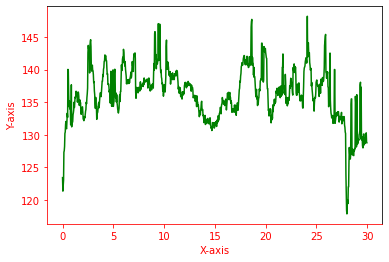

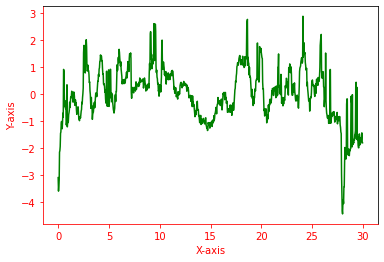

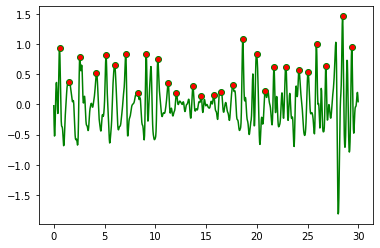

[ 0.56666667  1.53333333  2.56666667  4.2         5.13333333  6.
  7.06666667  8.26666667  9.1        10.23333333 11.26666667 12.06666667
 13.7        14.5        15.73333333 16.5        17.63333333 18.6
 19.96666667 20.83333333 21.66666667 22.83333333 24.13333333 25.03333333
 25.86666667 26.8        28.43333333 29.33333333]


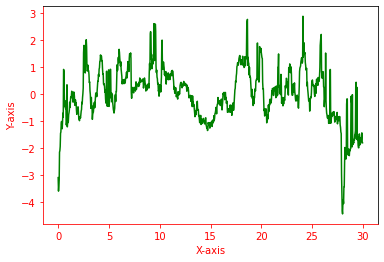

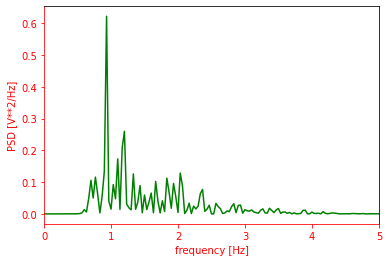

[2021-04-22 07:45:28,689] [INFO] [find_hr_in_window] [129] : Window 0:
Highest freq:0.9333333333333333
Heart rate: 56.0


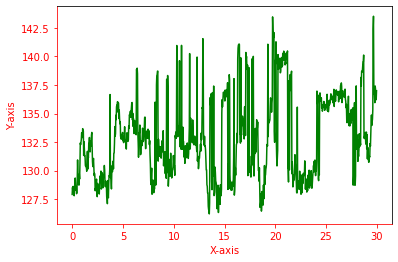

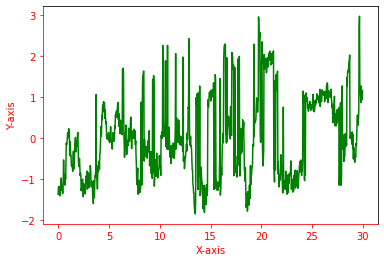

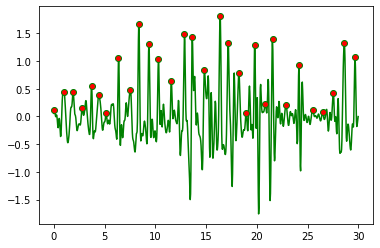

[ 0.06666667  0.96666667  1.9         2.8         3.73333333  4.43333333
  5.16666667  6.36666667  7.53333333  8.36666667  9.36666667 10.3
 11.56666667 12.86666667 13.63333333 14.83333333 16.36666667 17.16666667
 18.23333333 18.93333333 19.76666667 20.83333333 21.53333333 22.86666667
 24.13333333 25.5        26.46666667 27.53333333 28.6        29.66666667]


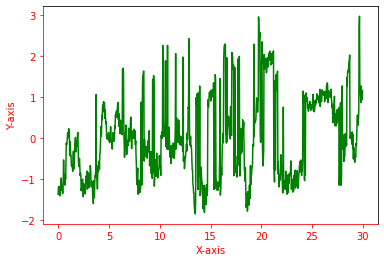

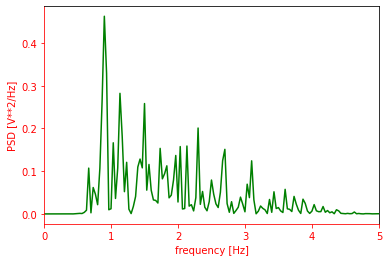

[2021-04-22 07:45:29,874] [INFO] [find_hr_in_window] [129] : Window 1:
Highest freq:0.9
Heart rate: 54.0


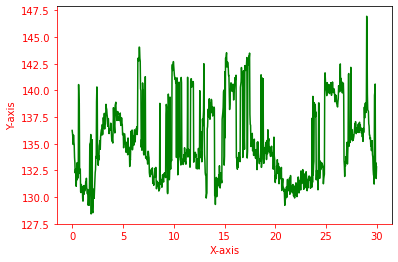

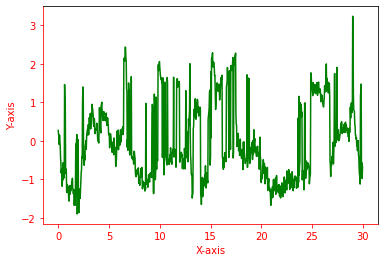

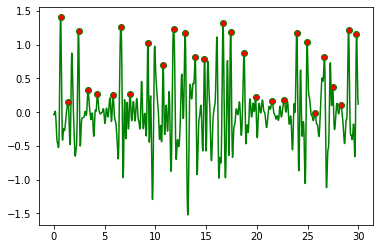

[ 0.66666667  1.4         2.43333333  3.36666667  4.3         5.83333333
  6.6         7.5         9.26666667 10.76666667 11.8        12.93333333
 13.93333333 14.83333333 16.66666667 17.4        18.73333333 19.86666667
 21.5        22.7        23.93333333 24.93333333 25.7        26.63333333
 27.46666667 28.23333333 29.03333333 29.8       ]


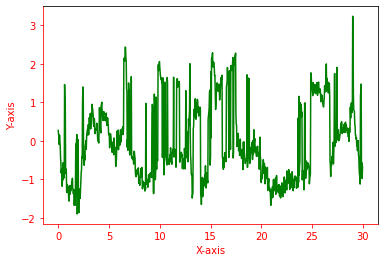

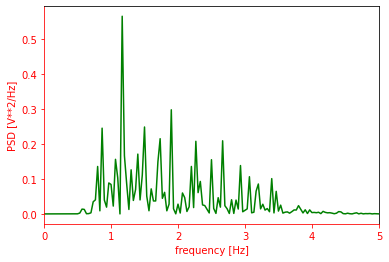

[2021-04-22 07:45:30,867] [INFO] [find_hr_in_window] [129] : Window 2:
Highest freq:1.1666666666666667
Heart rate: 70.0


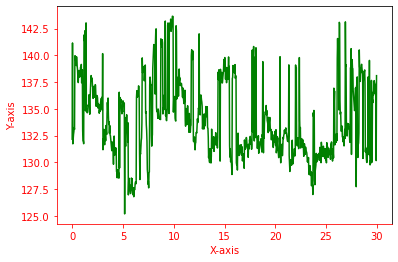

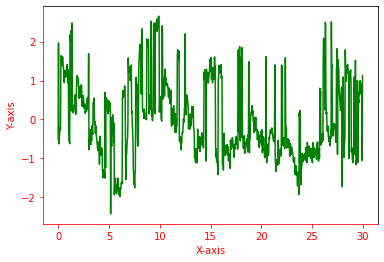

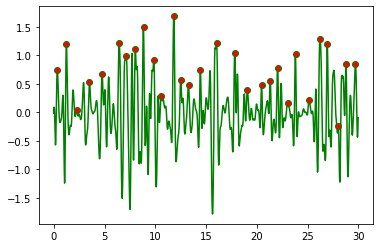

[ 0.33333333  1.23333333  2.26666667  3.5         4.76666667  6.43333333
  7.13333333  8.03333333  8.83333333  9.83333333 10.56666667 11.8
 12.5        13.26666667 14.43333333 16.03333333 17.8        19.06666667
 20.46666667 21.3        22.03333333 23.03333333 23.8        25.13333333
 26.2        26.93333333 28.         28.76666667 29.7       ]


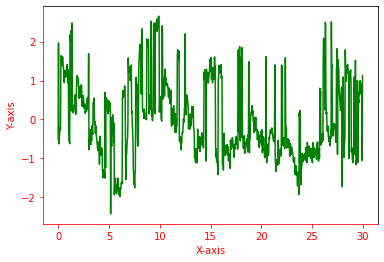

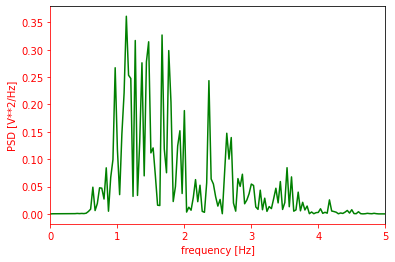

[2021-04-22 07:45:31,849] [INFO] [find_hr_in_window] [129] : Window 3:
Highest freq:1.1333333333333333
Heart rate: 68.0


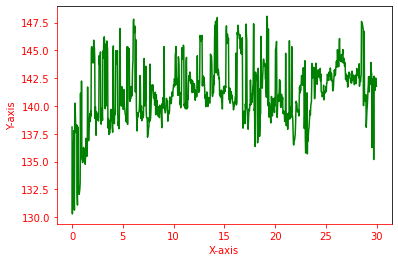

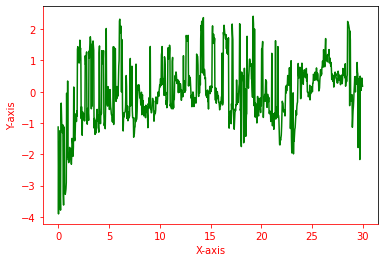

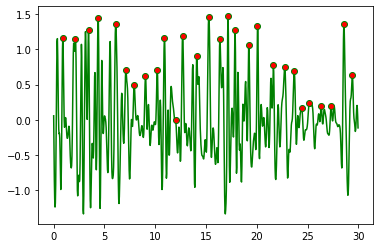

[ 0.9         2.13333333  3.43333333  4.36666667  6.1         7.1
  7.93333333  9.03333333 10.2        10.9        12.         12.7
 14.1        15.26666667 16.36666667 17.16666667 17.86666667 19.2
 20.06666667 21.63333333 22.73333333 23.66666667 24.43333333 25.16666667
 26.33333333 27.3        28.56666667 29.4       ]


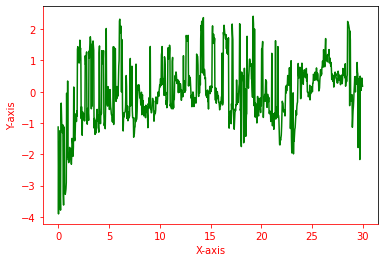

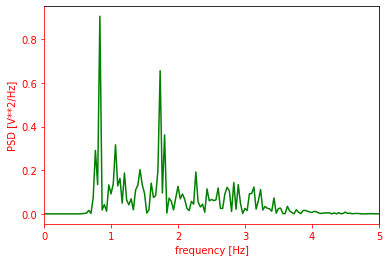

[2021-04-22 07:45:32,717] [INFO] [find_hr_in_window] [129] : Window 4:
Highest freq:0.8333333333333334
Heart rate: 50.0


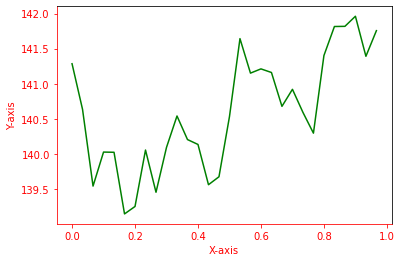

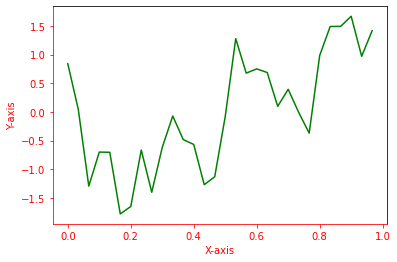

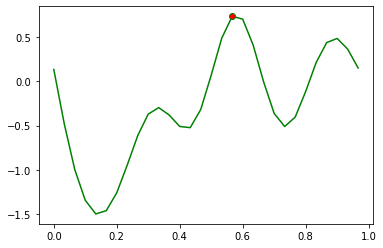

[0.56666667]


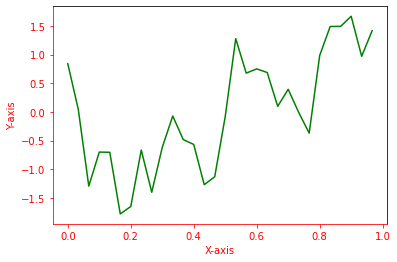

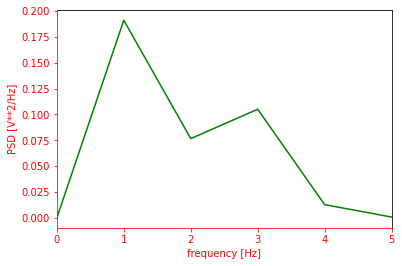

[2021-04-22 07:45:33,659] [INFO] [find_hr_in_window] [129] : Window 6:
Highest freq:1.0
Heart rate: 60.0


In [54]:
color_sig_array = np.asarray(color_sig)
red = color_sig_array[:,0]
green = color_sig_array[:,1]
blue = color_sig_array[:,2]

window_start = 0
window_size = 30
window_id = 0
limit = good_frame_number - int(round_fps) * window_size
while window_start < limit :
    find_hr_in_window(green, window_start, round_fps, window_id, window_size)
    window_start += int(round_fps) * window_size
    window_id += 1
if window_start < good_frame_number:
    window_id += 1
    find_hr_in_window(green, window_start, round_fps, window_id, good_frame_number - window_start)

ValueError: x and y must have same first dimension, but have shapes (900,) and (4530,)

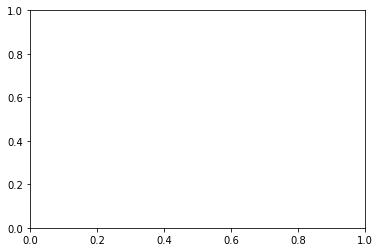

In [42]:
import pandas as pd
def indexes(y, thres=0.3, min_dist=1, thres_abs=False):
    if isinstance(y, np.ndarray) and np.issubdtype(y.dtype, np.unsignedinteger):
        raise ValueError("y must be signed")

    if not thres_abs:
        thres = thres * (np.max(y) - np.min(y)) + np.min(y)

    min_dist = int(min_dist)

    # compute first order difference
    dy = np.diff(y)

    # propagate left and right values successively to fill all plateau pixels (0-value)
    zeros, = np.where(dy == 0)

    # check if the signal is totally flat
    if len(zeros) == len(y) - 1:
        return np.array([])

    if len(zeros):
        # compute first order difference of zero indexes
        zeros_diff = np.diff(zeros)
        # check when zeros are not chained together
        zeros_diff_not_one, = np.add(np.where(zeros_diff != 1), 1)
        # make an array of the chained zero indexes
        zero_plateaus = np.split(zeros, zeros_diff_not_one)

        # fix if leftmost value in dy is zero
        if zero_plateaus[0][0] == 0:
            dy[zero_plateaus[0]] = dy[zero_plateaus[0][-1] + 1]
            zero_plateaus.pop(0)

        # fix if rightmost value of dy is zero
        if len(zero_plateaus) and zero_plateaus[-1][-1] == len(dy) - 1:
            dy[zero_plateaus[-1]] = dy[zero_plateaus[-1][0] - 1]
            zero_plateaus.pop(-1)

        # for each chain of zero indexes
        for plateau in zero_plateaus:
            median = np.median(plateau)
            # set leftmost values to leftmost non zero values
            dy[plateau[plateau < median]] = dy[plateau[0] - 1]
            # set rightmost and middle values to rightmost non zero values
            dy[plateau[plateau >= median]] = dy[plateau[-1] + 1]

    # find the peaks by using the first order difference
    peaks = np.where(
        (np.hstack([dy, 0.0]) < 0.0)
        & (np.hstack([0.0, dy]) > 0.0)
        & (np.greater(y, thres))
    )[0]

    # handle multiple peaks, respecting the minimum distance
    if peaks.size > 1 and min_dist > 1:
        highest = peaks[np.argsort(y[peaks])][::-1]
        rem = np.ones(y.size, dtype=bool)
        rem[peaks] = False

        for peak in highest:
            if not rem[peak]:
                sl = slice(max(0, peak - min_dist), peak + min_dist + 1)
                rem[sl] = True
                rem[peak] = False

        peaks = np.arange(y.size)[~rem]

    return peaks
green_buttered = filter_channel(green,round_fps)
peaks = indexes(green_buttered,min_dist=20)
x = np.arange(window_size,step=1/round_fps)
plt.plot(x,green_buttered,'-go',markerfacecolor='red',markevery=peaks)
plt.show()
print(x[peaks])
np.savetxt("time_of_peaks.csv", x[peaks], delimiter=",")

In [31]:
# a = Pxx_den
# ind = np.argsort(a)
# max_ind = ind[-5:]
# print(f[max_ind])
# print("HR for this video is: " +str(f[max_ind].mean()))

In [32]:
# if good_frame_number != greens.size: # TO BE REVIEW BY EYAL, POSSIBLE BUG FIX HERE!
#     frame_number = greens.size
# axis = np.arange((good_frame_number / round_fps), step=(1 / 30)) # axis is Time
# plot_result(greens, reds, blues, axis, "All 3 channels") # original signals
# # apply filtering on all the channels:
# green_buttered = filter_channel(greens,round_fps)
# red_buttered = filter_channel(reds,round_fps)
# blue_buttered = filter_channel(blues,round_fps)
# # plotting the channels after apllying the filter
# plot_result(green_buttered, red_buttered, blue_buttered, axis, "After Filter") # after filtering

In [33]:
# if good_frame_number != greens.size: # TO BE REVIEW BY EYAL, POSSIBLE BUG FIX HERE!
#     frame_number = greens.size
# axis = np.arange((good_frame_number / round_fps), step=(1 / 30)) # axis is Time
# plot_result(greens, reds, blues, axis, "All 3 channels") # original signals
# # apply filtering on all the channels:
# green_buttered = filter_channel(greens,round_fps)
# red_buttered = filter_channel(reds,round_fps)
# blue_buttered = filter_channel(blues,round_fps)
# # plotting the channels after apllying the filter
# plot_result(green_buttered, red_buttered, blue_buttered, axis, "After Filter") # after filtering

### PSD estimation using 'Welch' or 'Periodogram'

In [34]:
# f, Pxx_den = sig.welch(green_buttered, round_fps,'flattop', 1024, scaling='spectrum')

### Plot final results

In [35]:
# plt.figure(f, Pxx_den)
# #plt.semilogy(f, Pxx_den)
# plt.ylim([1e-7, 1e2])
# plt.xlabel('frequency [Hz]')
# plt.ylabel('PSD [V**2/Hz]')
# plt.show()
# # periodogram method:
# f, Pxx_den = sig.periodogram(green_buttered, round_fps)
# plt.semilogy(f, Pxx_den)
# plt.ylim([1e-7, 1e2])
# plt.xlabel('frequency [Hz]')
# plt.ylabel('PSD [V**2/Hz]')
# plt.show()